## Final Project Submission

Please fill out:
* Student name: Tim Sennett
* Student pace: self paced / **part time** / full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@timsennett/converting-integers-and-floats-to-datetime-in-pandas-4e754dc978fb


In this Module 3 Final Project, I was tasked with choosing a dataset for the purpose of creating a classification model. As per the constraints imposed by the instructor, the chosen dataset had to include a minimum of thirty thousand observations and 15–40 features (with a 2:1 ratio of numerical features to categorical features). The dataset also had to be suitable for classification, whether binary or multiclass.

After some searching, I chose the [2015 Flight Delays and Cancellations](https://www.kaggle.com/usdot/flight-delays#flights.csv) dataset. However, the dataset was quite large as constituted (564.96 MB), which led to my decision to work with only a subset of it, limited to three major airlines from the United States: Delta, American Airlines, and US Airways. The dataset includes information on approximately 1.8 million flights. A full list of features and their respective descriptions have been placed in the `columns.txt` file of this repository.

The present notebook documents the start-to-finish Data Science Process, from preprocessing and exploration to modeling and interpreting. Ultimately, this work aims to predict whether a flight will (1) depart at its scheduled time, or (2) be delayed or canceled. This is, of course, a *binary* classification problem.

Among the deliverables for this project is that I prepare and deliver a mock "executive summary" presentation to a hypothetical stakeholder of my choosing, describing my process and results in a non-technical manner, and making a case as to why my findings are important from a business perspective.

For whom might such a classification model provide business value? I've chosen to share my work with the leadership team of a mobile app development company that's creating an app for customers to know whether a given flight will be canceled or delayed—often before it's even announced by the airline—helping them to avoid wasted hours at an airport gate. The company's success hinges upon the app's ability to provide reliable, timely results to customers.

### Following the [OSEMN framework](https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492), the present notebook is organized according to the following basic steps:

1. Obtain
2. Scrub
3. Explore
4. Model
5. Interpret

## 1. Obtain
#### Gathering data from the relevant sources.

In [1]:
# Import libraries that I anticipate using.

import pandas as pd
pd.set_option('display.max_columns', 999)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
from datetime import date, timedelta, datetime, time

from scipy import stats

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In the next cell, I'll check to see what's in the current repository. I want to be sure to load the appropriate data.

In [2]:
ls

README.md            columns.txt          flights_us.csv
airlines.csv         flights_clean.csv    student.ipynb
airports.csv         flights_cleaned.csv


I'm going to need to `flights_us.csv` file, so I'll now import that as a Pandas DataFrame.

In [3]:
flights = pd.read_csv('flights_us.csv')

In [4]:
# Make sure I can see all the columns
pd.set_option('display.max_columns', 999)

# Check to see that my data imported properly.
flights.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Scrub
#### Clean data to format that machine understands.

In the next few cells, I'll look to understand the dimensionality of my dataset, and get a feel for what sort of data it contains. I'll also be on the lookout for signs of any missing data.

In [5]:
flights.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800580 entries, 0 to 1800579
Data columns (total 32 columns):
Unnamed: 0             1800580 non-null int64
YEAR                   1800580 non-null int64
MONTH                  1800580 non-null int64
DAY                    1800580 non-null int64
DAY_OF_WEEK            1800580 non-null int64
AIRLINE                1800580 non-null object
FLIGHT_NUMBER          1800580 non-null int64
TAIL_NUMBER            1794353 non-null object
ORIGIN_AIRPORT         1800580 non-null object
DESTINATION_AIRPORT    1800580 non-null object
SCHEDULED_DEPARTURE    1800580 non-null int64
DEPARTURE_TIME         1782600 non-null float64
DEPARTURE_DELAY        1782600 non-null float64
TAXI_OUT               1781895 non-null float64
WHEELS_OFF             1781895 non-null float64
SCHEDULED_TIME         1800580 non-null float64
ELAPSED_TIME           1777433 non-null float64
AIR_TIME               1777433 non-null float64
DISTANCE               1800580 non-null i

The DataFrame includes 32 total features and 1,800,579 observations.

Before doing much else, I want to remove the `Unnamed: 0` column, which serves no purpose. And after that, I'm going to make the column names titlecase, due to personal preference.

In [6]:
# Remove irrelevant column
flights.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Change columns to titlecase
flights.columns = map(str.title, flights.columns)

It's also clear that there are some null values present in the data, especially in the last six columns. Let me now get a count of exactly how many there are in each column:

In [8]:
flights.isnull().sum()

Year                         0
Month                        0
Day                          0
Day_Of_Week                  0
Airline                      0
Flight_Number                0
Tail_Number               6227
Origin_Airport               0
Destination_Airport          0
Scheduled_Departure          0
Departure_Time           17980
Departure_Delay          17980
Taxi_Out                 18685
Wheels_Off               18685
Scheduled_Time               0
Elapsed_Time             23147
Air_Time                 23147
Distance                     0
Wheels_On                19193
Taxi_In                  19193
Scheduled_Arrival            0
Arrival_Time             19193
Arrival_Delay            23147
Diverted                     0
Cancelled                    0
Cancellation_Reason    1781770
Air_System_Delay       1515729
Security_Delay         1515729
Airline_Delay          1515729
Late_Aircraft_Delay    1515729
Weather_Delay          1515729
dtype: int64

Those last five columns are intended to detail the number of minutes a flight was delayed for some given reason. That so many of these are null—and that the same number of nulls exist in each of them—leads me to suppose that these belong to the vast majority of flights that did not experience any delay.

How frequently is a flight's departure delayed anyway?

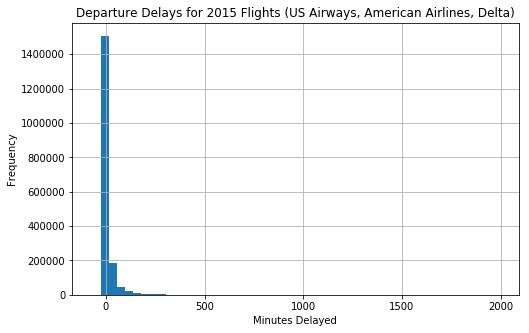

In [9]:
flights.hist(column= ['Departure_Delay'], figsize = (8, 5), bins=50);
plt.title("Departure Delays for 2015 Flights (US Airways, American Airlines, Delta)")
plt.xlabel("Minutes Delayed")
plt.ylabel("Frequency")
plt.show()

Much more often than not, planes are departing on time! Good news for customers of these three airlines.

But I'll look at the value counts for these five delay-reason features to get a clearer idea of what they're saying:

In [10]:
cols = ['Air_System_Delay', 'Security_Delay', 'Airline_Delay',
        'Late_Aircraft_Delay', 'Weather_Delay']

for col in cols:
    print(flights[col].value_counts().head(8),'\n')

0.0     126530
15.0      7296
16.0      6734
17.0      5820
1.0       5513
18.0      5482
2.0       5295
4.0       4972
Name: Air_System_Delay, dtype: int64 

0.0     283690
1.0         58
8.0         51
3.0         49
5.0         49
15.0        46
10.0        45
6.0         44
Name: Security_Delay, dtype: int64 

0.0     133350
1.0       5696
2.0       5504
3.0       5327
5.0       5006
4.0       4980
6.0       4648
15.0      4322
Name: Airline_Delay, dtype: int64 

0.0     163495
15.0      3223
16.0      3132
17.0      2943
18.0      2758
19.0      2619
14.0      2606
13.0      2528
Name: Late_Aircraft_Delay, dtype: int64 

0.0     261324
6.0        651
8.0        606
10.0       602
9.0        597
7.0        593
3.0        571
5.0        562
Name: Weather_Delay, dtype: int64 



The most common value in all of these columns is 0.0 (minutes), which indicates that a given flight experienced no delay for the reason indicated in the column name, but did experience a delay for one or more of the other four listed reasons. (This becomes apparent when viewing the top 50 rows of data.)

In [11]:
# look around and compare `Arrival_Delay` / `Departure_Delay` with the
# five delay-reason features

flights[['Departure_Delay', 'Arrival_Delay', 'Air_System_Delay',
         'Security_Delay','Airline_Delay','Late_Aircraft_Delay',
         'Weather_Delay']].head(50)

,Departure_Delay,Arrival_Delay,Air_System_Delay,Security_Delay,Airline_Delay,Late_Aircraft_Delay,Weather_Delay
0,-8.0,-9.0,NaN,NaN,NaN,NaN,NaN
1,-2.0,5.0,NaN,NaN,NaN,NaN,NaN
2,-5.0,-9.0,NaN,NaN,NaN,NaN,NaN
3,-5.0,8.0,NaN,NaN,NaN,NaN,NaN
4,14.0,-10.0,NaN,NaN,NaN,NaN,NaN
5,-11.0,-13.0,NaN,NaN,NaN,NaN,NaN
6,3.0,-15.0,NaN,NaN,NaN,NaN,NaN
7,-6.0,-30.0,NaN,NaN,NaN,NaN,NaN
8,-8.0,-10.0,NaN,NaN,NaN,NaN,NaN
9,0.0,-4.0,NaN,NaN,NaN,NaN,NaN


Interesting...

There are a number of instances where a flight has positive values in `Departure_Delay` and/or `Arrival_Delay`, but nothing but NaN in the five delay-reason features at the end of the DataFrame, or where the sum of the delay-reason features doesn't add up to the sum of `Departure_Delay` and/or `Arrival_Delay`.

Those peculiarities, plus the fact that the vast majority of values in these delay-reason columns are missing, leads me to think that I might as well remove these five columns. Besides, any time spent in delay is already well accounted for in `Departure_Delay` and/or `Arrival_Delay`.

In [12]:
# Remove time-reason columns
flights.drop(columns=['Air_System_Delay','Security_Delay','Airline_Delay',
                      'Late_Aircraft_Delay','Weather_Delay'], inplace=True)

I'll now take a moment to review the summary statistics of my data:

In [13]:
flights.describe()

,Year,Month,Day,Day_Of_Week,Flight_Number,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled
count,1800580.0,1.800580e+06,1.800580e+06,1.800580e+06,1.800580e+06,1.800580e+06,1.782600e+06,1.782600e+06,1.781895e+06,1.781895e+06,1.800580e+06,1.777433e+06,1.777433e+06,1.800580e+06,1.781387e+06,1.781387e+06,1.800580e+06,1.781387e+06,1.777433e+06,1.800580e+06,1.800580e+06
mean,2015.0,6.552891e+00,1.570553e+01,3.931403e+00,1.449080e+03,1.323821e+03,1.327418e+03,7.849869e+00,1.782555e+01,1.351658e+03,1.580859e+02,1.521888e+02,1.264530e+02,9.356964e+02,1.486713e+03,7.924253e+00,1.510193e+03,1.492125e+03,1.880781e+00,2.408668e-03,1.044663e-02
std,0.0,3.394445e+00,8.775427e+00,1.989754e+00,7.212022e+02,4.897736e+02,5.009566e+02,3.799542e+01,9.313224e+00,5.029980e+02,7.712393e+01,7.677795e+01,7.474238e+01,6.312766e+02,5.155672e+02,5.863696e+00,5.031473e+02,5.202333e+02,4.033303e+01,4.901906e-02,1.016735e-01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-6.800000e+01,1.000000e+00,1.000000e+00,2.500000e+01,3.000000e+01,1.500000e+01,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,8.600000e+02,9.100000e+02,9.130000e+02,-5.000000e+00,1.200000e+01,9.290000e+02,9.900000e+01,9.500000e+01,7.100000e+01,4.600000e+02,1.101000e+03,5.000000e+00,1.116000e+03,1.106000e+03,-1.500000e+01,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.512000e+03,1.319000e+03,1.324000e+03,-2.000000e+00,1.500000e+01,1.337000e+03,1.390000e+02,1.330000e+02,1.070000e+02,7.590000e+02,1.517000e+03,6.000000e+00,1.530000e+03,1.522000e+03,-7.000000e+00,0.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,2.033000e+03,1.730000e+03,1.736000e+03,4.000000e+00,2.000000e+01,1.751000e+03,1.960000e+02,1.900000e+02,1.620000e+02,1.217000e+03,1.921000e+03,9.000000e+00,1.927000e+03,1.926000e+03,5.000000e+00,0.000000e+00,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,2.853000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,7.180000e+02,7.110000e+02,6.690000e+02,4.983000e+03,2.400000e+03,2.480000e+02,2.359000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00


Some immediate observations:

- `Cancellation_Reason` has a large majority of null values, likely whenever a flight was not canceled.
- The `Month` column contains values ranging from 1 to 12; the `Day` columns contains values from 1 to 31, and the values in the `Day_Of_Week` column range from 1 to 7. Since these values are not of a continuous nature, **it would probably be best to convert these—along with the `Year` column—to datetime**.


- The `Wheels_Off` and `Wheels_On` columns contain values specifying the time-point that the aircraft's wheels left and touched the ground, respectively (e.g,. 811.0 might mean that the wheels left ground at 8:11, and 1517.00 might mean that the wheels touched the ground at 15:17, etc.). **They should be converted to datatime dtype**.
- `Arrival_Time` is a float value that sums `Wheels_On` and `Taxi_In`, where `Taxi_In` specifies the time duration (in minutes) elapsed between `Wheels_On` and `Arrival_Time` at the destination airport. **This too should be converted to datetime dtype**.
- Like, `Arrival_Time`, `Departure Time` is on a 1 to 2400 scale, and it is a float value that subtracts `Taxi_Out` from `Wheel_Off`. **It, as well, should be converted to datetime dtype**.
- `Scheduled_Departure` and `Scheduled_Arrival` contain values ranging from 1 to 2359, specifying a time-point. **These should be converted to datetime dtype**.


- Since `Flight_Number` has no continuous value, it might be best to convert from int64 to categorical dtype. Or, since flight numbers usually follow certain industry conventions (e.g., four-digit numbers in the range 3000 to 5999 typically represent regional affiliate flights), then binning is another option to keep in mind.
- `Departure_Delay` and `Arrival_Delay` specify the number of minutes that a flight departed or arrived late (or early, if the value is negative).
- `Diverted` and `Canceled` columns have binary (0-1) values, indicating whether or not a flight landed in a different airport than scheduled, or was canceled, respectively.

I'll start by further investigating the many null values in the Cancellation_Reason column.

In [14]:
# Check updated null totals
flights.isnull().sum()

Year                         0
Month                        0
Day                          0
Day_Of_Week                  0
Airline                      0
Flight_Number                0
Tail_Number               6227
Origin_Airport               0
Destination_Airport          0
Scheduled_Departure          0
Departure_Time           17980
Departure_Delay          17980
Taxi_Out                 18685
Wheels_Off               18685
Scheduled_Time               0
Elapsed_Time             23147
Air_Time                 23147
Distance                     0
Wheels_On                19193
Taxi_In                  19193
Scheduled_Arrival            0
Arrival_Time             19193
Arrival_Delay            23147
Diverted                     0
Cancelled                    0
Cancellation_Reason    1781770
dtype: int64

Now, I'm going to investigate the many null values in the `Cancellation_Reason` column.

In [15]:
print("Value counts in 'Cancellation_Reason':",
      flights['Cancellation_Reason'].value_counts(),'\n')

print("Total null values in 'Cancellation_Reason':",
      flights['Cancellation_Reason'].isnull().sum())

print("Total non-canceled flights:",
      len(flights[flights['Cancelled']==0]))

Value counts in 'Cancellation_Reason': B    12769
A     4480
C     1557
D        4
Name: Cancellation_Reason, dtype: int64 

Total null values in 'Cancellation_Reason': 1781770
Total non-canceled flights: 1781770


There are four given categories in the `Cancellation_Reason` column. But these categories are only assigned to the relatively few flights that are canceled. Evidently, all non-canceled flights (flights with a '0' in the `Cancelled` column, of which there are 1,781,770) are assigned null values in `Cancellation_Reason`.

Knowing this, it makes sense to create a fifth category in `Cancellation_Reason` for the majority of flights that were not canceled. And later, I'll remember to transform this piece of categorical data through one-hot encoding. (This involves converting each category into a new column, and assigning a 1 or 0 to the column. This way my model will be able to handle the data.)

In [16]:
# Assign all non-canceled flights to value 'E' in 'Cancellation_Reason' column
flights['Cancellation_Reason'].fillna(value='E', inplace=True)

# Set to categorical type, since these are a small number of fixed values
flights['Cancellation_Reason'] = flights.Cancellation_Reason.astype('category')

# Sanity check
print(flights['Cancellation_Reason'].value_counts())

E    1781770
B      12769
A       4480
C       1557
D          4
Name: Cancellation_Reason, dtype: int64


In [17]:
# Check updated null totals
flights.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number             6227
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         17980
Departure_Delay        17980
Taxi_Out               18685
Wheels_Off             18685
Scheduled_Time             0
Elapsed_Time           23147
Air_Time               23147
Distance                   0
Wheels_On              19193
Taxi_In                19193
Scheduled_Arrival          0
Arrival_Time           19193
Arrival_Delay          23147
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

I notice there are a number of columns that all have a fairly similar amount of null-values (between 17980-23147), given the overall size of the dataset:

- `Elapsed_Time`
- `Air_Time`
- `Wheels_On`
- `Wheels_Off`
- `Taxi_In`
- `Taxi_Out`
- `Departure_Time`
- `Departure_Delay`
- `Arrival_Time`
- `Arrival_Delay`

My suspicion is that many of these null values may be due to their association with the 18810 flights that were canceled. Let's look more closely:

In [18]:
# Create subset of canceled flights only
cancelled = flights[flights['Cancelled']==1]

print('Number of canceled flights:', len(cancelled))

# View the relevant subset of data
cancelled[['Elapsed_Time','Air_Time','Wheels_On', 'Wheels_Off','Taxi_In',
           'Taxi_Out','Departure_Time','Departure_Delay','Arrival_Time',
           'Arrival_Delay']].head()

Number of canceled flights: 18810


,Elapsed_Time,Air_Time,Wheels_On,Wheels_Off,Taxi_In,Taxi_Out,Departure_Time,Departure_Delay,Arrival_Time,Arrival_Delay
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It stands to reason that these values are null because a canceled flight simply can't have an air time or an arrival time, etc.

I can't remove these rows which contain null values, because, even though they constitute a very small portion of the overall data, it appears they include most of if not *all* of the canceled flights. Not a good idea if my end-goal is to make predictions about flight delays/cancellations.

And I obviously can't remove these ten columns, either, because they contain valuable data on the many flights that were not canceled.

Another choice I have is to set all of these null values to '0', since, well, I imagine it's technically true in many cases. (A canceled flight literally spends zero minutes in the air, right?)

(In the case of `Wheels_On`, `Wheels_Off`, `Departure_Time`, and `Arrival_Time`, I can consider assigning '-1' to missing values, because the values in this column are meant to represent a time-point rather than a time duration, and -1 would more clearly represent a non-applicable value. But I have to keep in mind that I intend to eventually convert these features to datetime, and having negative values in the mix would interfere with that step. So I'm going to leave them alone for now.)

Before replacing any null values with '0', I'm curious to know if there are any columns in this subset of canceled flights that contains nothing but null values.

In [19]:
cols = ['Elapsed_Time','Air_Time','Wheels_On', 'Wheels_Off','Taxi_In',
        'Taxi_Out','Departure_Time','Departure_Delay','Arrival_Time',
        'Arrival_Delay']

for col in cols:
    print(cancelled[col].value_counts().head(),'\n')

Series([], Name: Elapsed_Time, dtype: int64) 

Series([], Name: Air_Time, dtype: int64) 

Series([], Name: Wheels_On, dtype: int64) 

2233.0    2
2311.0    2
1622.0    2
1354.0    2
751.0     2
Name: Wheels_Off, dtype: int64 

Series([], Name: Taxi_In, dtype: int64) 

12.0    13
11.0    11
18.0    11
16.0    10
13.0     7
Name: Taxi_Out, dtype: int64 

1334.0    4
556.0     4
1726.0    4
1351.0    4
1758.0    4
Name: Departure_Time, dtype: int64 

-2.0    42
-6.0    37
-3.0    35
-4.0    31
-1.0    28
Name: Departure_Delay, dtype: int64 

Series([], Name: Arrival_Time, dtype: int64) 

Series([], Name: Arrival_Delay, dtype: int64) 



Six out of the ten columns in this subset contain null values only. Of those six, I'll replace null values with '0'  in four of them, and then update the original DataFrame accordingly. (I'll leave the other two, `Wheels_On` and `Arrival_Time`, which are time-point features, alone for now.)

In [20]:
cancelled['Elapsed_Time'].fillna(value=0, inplace=True)
cancelled['Air_Time'].fillna(value=0, inplace=True)
cancelled['Taxi_In'].fillna(value=0, inplace=True)
cancelled['Arrival_Delay'].fillna(value=0, inplace=True)

# Update flights df to reflect replaced NaNs from cancelled df
flights.update(cancelled)

In [21]:
# Check updated null totals in flights df
# Notice that some NaNs still remain in these four columns,
# because they must not be coming from canceled flights

flights.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number             6227
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         17980
Departure_Delay        17980
Taxi_Out               18685
Wheels_Off             18685
Scheduled_Time             0
Elapsed_Time            4337
Air_Time                4337
Distance                   0
Wheels_On              19193
Taxi_In                  383
Scheduled_Arrival          0
Arrival_Time           19193
Arrival_Delay           4337
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

In [22]:
# check updated null values in cancelled df

cancelled.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number             6227
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         17980
Departure_Delay        17980
Taxi_Out               18685
Wheels_Off             18685
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              18810
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           18810
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

Now, among canceled flights, only seven columns remain which have null values. Four of them represent time-point data and will be left alone for now in order to receive special treatment later. The others are:

- `Departure_Delay`: This represents the total duration of departure delay, in minutes.
- `Taxi_Out`: This represents a time duration between `Departure_Time` and `Wheels_Off`.
- `Tail_Number`: Since a plane's tail number is essentially nothing but a unique ID, these 6227 values can't be filled with any median or mode; and it's hard to justify replacing it with something extraneous like "9999". (It appears that all the flights with missing tail numbers also happen to have been labeled as canceled.) I'll simply drop these rows.

In [23]:
# drop rows from both dfs

flights.dropna(subset=['Tail_Number'], inplace = True)
cancelled.dropna(subset=['Tail_Number'], inplace = True)

In [24]:
# updated null values

cancelled.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay        11753
Taxi_Out               12458
Wheels_Off             12458
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              12583
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           12583
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

Note that the values in `Departure_Delay` and `Taxi_Out` tend to be null whenever a flight is canceled. But that isn't always the case...

In [25]:
print('Number of canceled flights:', len(cancelled),'\n')

Number of canceled flights: 12583 



Not every canceled flight is filled with null values in `Departure_Delay` and `Taxi_Out` (or, for that matter, `Wheels_Off` and `Departure_Time`). There are currently 12583 total canceled flights, but not as many null values in any of these four columns. **Look at the peculiarity below, for example.**

It appears that some canceled flights have *positive* values in the `Wheels_Off` column, indicating that they actually left the ground:

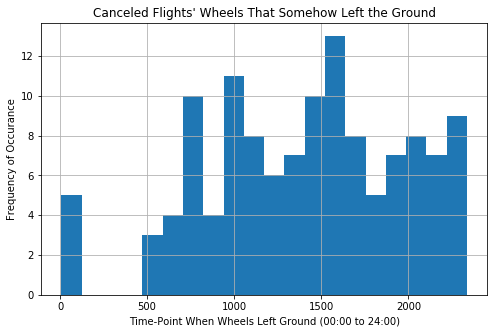

125 cancelled flights supposedly left the ground!


In [26]:
cancelled['Wheels_Off'].hist(figsize=(8,5), bins=20)
plt.title("Canceled Flights' Wheels That Somehow Left the Ground")
plt.xlabel("Time-Point When Wheels Left Ground (00:00 to 24:00)")
plt.ylabel("Frequency of Occurance")
plt.show()

# Calculate difference of total canceled flights and canceled flights w/
# null values in `Wheels_Off`
print(len(cancelled[cancelled['Wheels_Off'].isnull()==False]),
      "cancelled flights supposedly left the ground!")

Very strange indeed. After taking off, did any of these canceled flights wheels' ever come back to touch the ground?

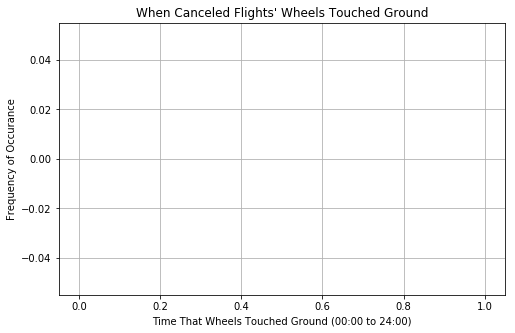

In [27]:
cancelled['Wheels_On'].hist(figsize=(8,5), bins=20)
plt.title("When Canceled Flights' Wheels Touched Ground")
plt.xlabel("Time That Wheels Touched Ground (00:00 to 24:00)")
plt.ylabel("Frequency of Occurance")
plt.show()

No canceled flights are recorded as having touched the ground, so I'm perplexed as to how they ended up leaving the ground. Or was this just an input error? Let me subset the data further, and take a detailed look at these 125 flights.

In [28]:
cancelled_wheels_off = cancelled[cancelled['Wheels_Off'].isnull()==False]
cancelled_wheels_off.head()

,Year,Month,Day,Day_Of_Week,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled,Cancellation_Reason
13472,2015,1,3,6,AA,2300,N556AA,DFW,ICT,2230,2356.0,86.0,11.0,7.0,75.0,0.0,0.0,328,NaN,0.0,2345,NaN,0.0,0,1,B
29605,2015,1,7,3,AA,1476,N3DSAA,LAS,MIA,1115,1109.0,-6.0,16.0,1125.0,274.0,0.0,0.0,2174,NaN,0.0,1849,NaN,0.0,0,1,A
35089,2015,1,8,4,DL,1116,N334NB,ATL,MDW,1347,1345.0,-2.0,9.0,1354.0,113.0,0.0,0.0,591,NaN,0.0,1440,NaN,0.0,0,1,B
36887,2015,1,8,4,US,494,N584UW,PHX,DEN,1955,1949.0,-6.0,22.0,2011.0,108.0,0.0,0.0,602,NaN,0.0,2143,NaN,0.0,0,1,B
42727,2015,1,10,6,US,1933,N951UW,PHL,ORD,730,729.0,-1.0,15.0,744.0,153.0,0.0,0.0,678,NaN,0.0,903,NaN,0.0,0,1,A


Hopefully an explanation will reveal itself in time...

Right now, I think the most prudent decision is to say farewell to those 125 mysterious observations.

In [29]:
# I'll drop them from both dfs

flights.drop(cancelled[cancelled['Wheels_Off'].isnull()==False].index, 
             inplace=True)
cancelled.drop(cancelled[cancelled['Wheels_Off'].isnull()==False].index,
               inplace=True)

In [30]:
print(f"Updated number of canceled flights: {len(cancelled)}")

Updated number of canceled flights: 12458


In [31]:
# Review NaN totals

cancelled.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay        11753
Taxi_Out               12458
Wheels_Off             12458
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              12458
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           12458
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

Notice that with those 125 observations removed from the data, the null count in `Taxi_Out` and `Wheels_Off` now perfectly matches the number of canceled flights.

Leaving `Wheels_Off` alone for now, I'll fill in the null values in `Taxi_Out` with '0'. (Because, in a literal sense, these canceled flights spent zero minutes taxing in.):

In [32]:
cancelled['Taxi_Out'].fillna(value=0, inplace=True)

# update original df to reflect the change
flights.update(cancelled)

In [33]:
# Check updated NaN totals

cancelled.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay        11753
Taxi_Out                   0
Wheels_Off             12458
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              12458
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           12458
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

It certainly looks as if among these 12458 canceled flights there are 705 of them that have non-null values in columns where one would not expect any: `Departure_Time` and `Departure_Delay`. Anything non-null here would curiously seem to indicate that a canceled flight somehow *might have had a departure*.

In [34]:
# Number of "cancelled" flights with values in departure columns
print(len(cancelled[cancelled['Departure_Time'].isnull()==False]))
print(len(cancelled[cancelled['Departure_Delay'].isnull()==False]))

705
705


Allow me to look more closely:

In [35]:
# subset cancelled flights that have a departure time
cancelled_departed = cancelled[cancelled['Departure_Time'].notnull()]
cancelled_departed.head()

,Year,Month,Day,Day_Of_Week,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled,Cancellation_Reason
4991,2015,1,2,5,AA,1222,N4WTAA,TUS,DFW,815,821.0,6.0,0.0,NaN,130.0,0.0,0.0,813,NaN,0.0,1125,NaN,0.0,0,1,A
12174,2015,1,3,6,DL,2640,N958AT,ICT,ATL,1635,1830.0,115.0,0.0,NaN,126.0,0.0,0.0,782,NaN,0.0,1941,NaN,0.0,0,1,A
23119,2015,1,5,1,AA,1384,N467AA,ORD,MSP,2055,25.0,210.0,0.0,NaN,85.0,0.0,0.0,334,NaN,0.0,2220,NaN,0.0,0,1,B
23199,2015,1,5,1,US,831,N555AY,ORD,CLT,2135,2227.0,52.0,0.0,NaN,114.0,0.0,0.0,599,NaN,0.0,29,NaN,0.0,0,1,B
24652,2015,1,6,2,US,1809,N961UW,BOS,PHL,930,930.0,0.0,0.0,NaN,96.0,0.0,0.0,280,NaN,0.0,1106,NaN,0.0,0,1,B


This is quite odd.

Somehow, someway, these flights have a `Departure_Time` attributed to them, even while having nothing in `Wheel_Off` and `Taxi_Out`. (Remember, `Departure_Time` is a *function* of `Wheel_Off` and `Taxi_Out`!)

I must say I'm not comfortable with the way this looks. Since this only amounts to 705 observations (or 5.7% of remaining "canceled" flights), I'd love to say goodbye to these rows for good. Here, I'll drop these "cancelled" flights that somehow have non-null values in departure columns.

In [36]:
# I'll drop them from both dfs

flights.drop(cancelled[cancelled['Departure_Time'].notnull()].index, 
             inplace=True)
cancelled.drop(cancelled[cancelled['Departure_Time'].notnull()].index,
               inplace=True)

In [37]:
# Check updated cancelled flights total
# Check updated NaN totals

print(len(cancelled))
cancelled.isnull().sum()

11753


Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay        11753
Taxi_Out                   0
Wheels_Off             11753
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              11753
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           11753
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

With the number of null values in `Departure_Delay` now matching the total of canceled flights, it's a good time to replace those 11753 missing values with '0' in the subset of canceled flights (and, in a corresponding move, to update the original DataFrame with those changes.)

In [38]:
cancelled['Departure_Delay'].fillna(value=0, inplace=True)

# update original df
flights.update(cancelled)

In [39]:
# Check updated null totals

flights.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay            0
Taxi_Out                   0
Wheels_Off             11753
Scheduled_Time             0
Elapsed_Time            4337
Air_Time                4337
Distance                   0
Wheels_On              12136
Taxi_In                  383
Scheduled_Arrival          0
Arrival_Time           12136
Arrival_Delay           4337
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

Only four columns left with null values among all canceled flights! And the four that remain are the time-point values that I'll be getting to soon enough. Those will receive unique treatment.

Before directly dealing with them, I want to take a moment to address the null value in the four time-duration features: `Elapsed_Time`, `Air_Time`, `Taxi_In` and `Arrival_Delay`.

In [40]:
# check out flights where 'Elapsed_Time' values are missing
flights[flights['Elapsed_Time'].isnull()].head()

,Year,Month,Day,Day_Of_Week,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled,Cancellation_Reason
210,2015.0,1.0,1.0,4.0,DL,716.0,N944DL,OMA,ATL,645.0,637.0,-8.0,27.0,704.0,144.0,NaN,NaN,821.0,1447.0,4.0,1009.0,1451.0,NaN,1.0,0.0,E
1273,2015.0,1.0,1.0,4.0,AA,1279.0,N541AA,OMA,DFW,1100.0,1058.0,-2.0,12.0,1110.0,120.0,NaN,NaN,583.0,1826.0,12.0,1300.0,1838.0,NaN,1.0,0.0,E
2780,2015.0,1.0,1.0,4.0,US,735.0,N657AW,PHL,LAS,1620.0,1617.0,-3.0,44.0,1701.0,336.0,NaN,NaN,2176.0,2100.0,7.0,1856.0,2107.0,NaN,1.0,0.0,E
7005,2015.0,1.0,2.0,5.0,US,500.0,N677AW,SEA,PHX,1500.0,1454.0,-6.0,14.0,1508.0,167.0,NaN,NaN,1107.0,1941.0,4.0,1847.0,1945.0,NaN,1.0,0.0,E
7443,2015.0,1.0,2.0,5.0,AA,297.0,N5FDAA,LAX,HNL,1625.0,1623.0,-2.0,21.0,1644.0,360.0,NaN,NaN,2556.0,1025.0,10.0,2025.0,1035.0,NaN,1.0,0.0,E


It so happens that when `Elapsed_Time` is NaN, so too is `Air_Time` and `Arrival_Delay`. The observations in question constitute a tiny fraction of the overall data, so I'll remove the rows with missing values in these columns.

In [41]:
# The share of the data w/ null values in 'Elapsed_Time'
len(flights[flights['Elapsed_Time'].isnull()]) / len(flights)

0.0024181457388614477

In [42]:
# drop rows where NaNs are present in 'Elapsed_Time'
flights.dropna(subset=['Elapsed_Time'], inplace = True)

In [43]:
# check out updated totals
flights.isnull().sum()

Year                       0
Month                      0
Day                        0
Day_Of_Week                0
Airline                    0
Flight_Number              0
Tail_Number                0
Origin_Airport             0
Destination_Airport        0
Scheduled_Departure        0
Departure_Time         11753
Departure_Delay            0
Taxi_Out                   0
Wheels_Off             11753
Scheduled_Time             0
Elapsed_Time               0
Air_Time                   0
Distance                   0
Wheels_On              11753
Taxi_In                    0
Scheduled_Arrival          0
Arrival_Time           11753
Arrival_Delay              0
Diverted                   0
Cancelled                  0
Cancellation_Reason        0
dtype: int64

It looks like that takes care of all the null values, with the lone exception of those found in four of the time-point features! (About those soon.)

Now, I want to convert `Year`, `Month` and `Day` to datetime dtype, and rename `Day_Of_Week` to `Weekday` (simply a personal preference). This will reduce the overall number of features and thus the dimensionality of the DataFrame.

In [44]:
# Add new column for date, comprised of Year, Month, Day
flights['Date'] = pd.to_datetime(flights[['Year','Month','Day']])

# Remove columns for Year, Month, Day
flights.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Duplicate Day_Of_Week as Weekday
flights['Weekday'] = flights['Day_Of_Week']

# Remove Day_Of_Week
flights.drop('Day_Of_Week', axis=1, inplace=True)

And since `Weekday` represents a fixed number of values, I'll convert this to categorical dtype. (A little bit later I'll one-hot-encode this feature.)

In [45]:
flights['Weekday'] = flights['Weekday'].astype('category')

In [46]:
# Make sure Date and Weekday are updated
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled,Cancellation_Reason,Date,Weekday
0,AA,2336.0,N3KUAA,LAX,PBI,10.0,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330.0,737.0,4.0,750.0,741.0,-9.0,0.0,0.0,E,2015-01-01,4.0
1,US,840.0,N171US,SFO,CLT,20.0,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296.0,800.0,11.0,806.0,811.0,5.0,0.0,0.0,E,2015-01-01,4.0
2,AA,258.0,N3HYAA,LAX,MIA,20.0,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342.0,748.0,8.0,805.0,756.0,-9.0,0.0,0.0,E,2015-01-01,4.0
3,DL,806.0,N3730B,SFO,MSP,25.0,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589.0,604.0,6.0,602.0,610.0,8.0,0.0,0.0,E,2015-01-01,4.0
4,US,2013.0,N584UW,LAX,CLT,30.0,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125.0,745.0,8.0,803.0,753.0,-10.0,0.0,0.0,E,2015-01-01,4.0


Now, any feature that contains data representing time-points would also be better suited for datetime. Those features are:

- `Departure_Time`
- `Arrival_Time`
- `Wheels_On`
- `Wheels_Off`
- `Scheduled_Departure`
- `Scheduled_Arrival`

In [47]:
# Subset the data
time_points = flights[['Departure_Time','Arrival_Time','Wheels_On',
                       'Wheels_Off','Scheduled_Departure',
                       'Scheduled_Arrival']]

# sanity check
time_points.head()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,2.0,741.0,737.0,14.0,10.0,750.0
1,18.0,811.0,800.0,34.0,20.0,806.0
2,15.0,756.0,748.0,30.0,20.0,805.0
3,20.0,610.0,604.0,38.0,25.0,602.0
4,44.0,753.0,745.0,57.0,30.0,803.0


In [48]:
time_points.describe()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
count,1.777433e+06,1.777433e+06,1.777433e+06,1.777433e+06,1.789186e+06,1.789186e+06
mean,1.327294e+03,1.492039e+03,1.486598e+03,1.351569e+03,1.323675e+03,1.509984e+03
std,5.009771e+02,5.197792e+02,5.151421e+02,5.030246e+02,4.898519e+02,5.032358e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,9.130000e+02,1.106000e+03,1.101000e+03,9.290000e+02,9.100000e+02,1.116000e+03
50%,1.324000e+03,1.522000e+03,1.517000e+03,1.337000e+03,1.318000e+03,1.530000e+03
75%,1.736000e+03,1.926000e+03,1.920000e+03,1.751000e+03,1.730000e+03,1.927000e+03
max,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.359000e+03,2.359000e+03


In [49]:
time_points.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1789186 entries, 0 to 1800579
Data columns (total 6 columns):
Departure_Time         float64
Arrival_Time           float64
Wheels_On              float64
Wheels_Off             float64
Scheduled_Departure    float64
Scheduled_Arrival      float64
dtypes: float64(6)
memory usage: 95.6 MB


Notice again that these six features represent time-points, as indicated by the fact that all of them are on a scale of 1 to 2400.

From experience, I know that the value 2400 as a representation of midnight is going to lead to errors later on when I convert these values to datetime. Another common representation of midnight is 00:00, so I'll begin by changing every '2400' to '0' in these six columns.

In [50]:
time_points.replace(2400, 0, inplace=True)

# check for updated min and max
time_points.describe()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
count,1.777433e+06,1.777433e+06,1.777433e+06,1.777433e+06,1.789186e+06,1.789186e+06
mean,1.326986e+03,1.490839e+03,1.485591e+03,1.351203e+03,1.323675e+03,1.509984e+03
std,5.010552e+02,5.204518e+02,5.157012e+02,5.031347e+02,4.898519e+02,5.032358e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,9.130000e+02,1.105000e+03,1.101000e+03,9.290000e+02,9.100000e+02,1.116000e+03
50%,1.324000e+03,1.521000e+03,1.517000e+03,1.337000e+03,1.318000e+03,1.530000e+03
75%,1.736000e+03,1.925000e+03,1.920000e+03,1.751000e+03,1.730000e+03,1.927000e+03
max,2.359000e+03,2.359000e+03,2.359000e+03,2.359000e+03,2.359000e+03,2.359000e+03


Now, in attempting to convert these columns to datetime, I need to remove the dot ('.'), provided that they are floats. That can be done simply by converting these to integers. Then, I'll immediately have those integers converted to strings, which is what they'll need to be in order to later be converted to datetime.

But first I subset the data so that the null values don't interfere with this conversion, because null values can't be cast into integers.

In [51]:
time_points_non_null = time_points.dropna()

In [52]:
time_points_non_null.head()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,2.0,741.0,737.0,14.0,10.0,750.0
1,18.0,811.0,800.0,34.0,20.0,806.0
2,15.0,756.0,748.0,30.0,20.0,805.0
3,20.0,610.0,604.0,38.0,25.0,602.0
4,44.0,753.0,745.0,57.0,30.0,803.0


In [53]:
cols = ['Departure_Time','Arrival_Time','Wheels_On','Wheels_Off',
        'Scheduled_Departure','Scheduled_Arrival']

for col in cols:
    time_points_non_null[col] = time_points_non_null[col].astype('int')
    time_points_non_null[col] = time_points_non_null[col].astype('str')
    
    print(time_points_non_null[col].dtype)
    
time_points_non_null.head()

object
object
object
object
object
object


,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,2,741,737,14,10,750
1,18,811,800,34,20,806
2,15,756,748,30,20,805
3,20,610,604,38,25,602
4,44,753,745,57,30,803


Now that I have the dots removed from all time-point values and everything cast as strings, I'll attempt to convert it into datetime. Since there's so much data, I'll cut out a small subset for trying out this for loop.

In [54]:
# subset the data for trial purposes

time_points_non_null_sub = time_points_non_null[0:5]
time_points_non_null_sub

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,2,741,737,14,10,750
1,18,811,800,34,20,806
2,15,756,748,30,20,805
3,20,610,604,38,25,602
4,44,753,745,57,30,803


In [55]:
# This for loop was previously tested
# It works, but takes far too long to execute

# for col in time_points_non_null_head:
#     i = 0
#     for val in time_points_non_null_head[col]:
#         time_points_non_null_head[col][i] = datetime.strptime(val.zfill(4), "%H%M")
#         i += 1

# time_points_non_null_head

When tested, the for loop above took well over a second when there were only five observations. If I ran this on all 1,800,455 observations then I estimate it would take around five days!

I'll try a different method. This time, a lambda function.

In [56]:
time_points_non_null_sub.applymap(lambda x: datetime.strptime(x.zfill(4), "%H%M").time())

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,00:02:00,07:41:00,07:37:00,00:14:00,00:10:00,07:50:00
1,00:18:00,08:11:00,08:00:00,00:34:00,00:20:00,08:06:00
2,00:15:00,07:56:00,07:48:00,00:30:00,00:20:00,08:05:00
3,00:20:00,06:10:00,06:04:00,00:38:00,00:25:00,06:02:00
4,00:44:00,07:53:00,07:45:00,00:57:00,00:30:00,08:03:00


Now that's a much improved execution time! Let's see how it goes when I run it on the nearly 1.8 million rows of the time_points_non_null DataFrame.

In [57]:
time_points_non_null = time_points_non_null.applymap(lambda x: datetime.strptime(x.zfill(4), "%H%M").time())
time_points_non_null.head()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,00:02:00,07:41:00,07:37:00,00:14:00,00:10:00,07:50:00
1,00:18:00,08:11:00,08:00:00,00:34:00,00:20:00,08:06:00
2,00:15:00,07:56:00,07:48:00,00:30:00,00:20:00,08:05:00
3,00:20:00,06:10:00,06:04:00,00:38:00,00:25:00,06:02:00
4,00:44:00,07:53:00,07:45:00,00:57:00,00:30:00,08:03:00


Wonderful! Took all of two minutes. Now I'll update my time_points DataFrame with this newly converted data in time_points_non_null.

In [58]:
# Bring time_point values up-to-date based on time_point_non_null,
# where indices between them are common

time_points.update(time_points_non_null)

# check to see that it's in datetime:
time_points.head()

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,00:02:00,07:41:00,07:37:00,00:14:00,00:10:00,07:50:00
1,00:18:00,08:11:00,08:00:00,00:34:00,00:20:00,08:06:00
2,00:15:00,07:56:00,07:48:00,00:30:00,00:20:00,08:05:00
3,00:20:00,06:10:00,06:04:00,00:38:00,00:25:00,06:02:00
4,00:44:00,07:53:00,07:45:00,00:57:00,00:30:00,08:03:00


In [59]:
# Note that this updated time_points DF retains the NaN values that
# had been left out from time_points_non_null DF

time_points.isnull().sum()

Departure_Time         11753
Arrival_Time           11753
Wheels_On              11753
Wheels_Off             11753
Scheduled_Departure        0
Scheduled_Arrival          0
dtype: int64

Since I've finished the process of converting these features to datetime, I should be able to reassign any null values here to empty strings, just as I've been intending to all along. Now I'm finally able to go ahead and do that: 

In [60]:
# Fill null values with empty strings

time_points['Departure_Time'].fillna(value='', inplace=True)
time_points['Arrival_Time'].fillna(value='', inplace=True)
time_points['Wheels_On'].fillna(value='', inplace=True)
time_points['Wheels_Off'].fillna(value='', inplace=True)

In [61]:
# check for the empty strings
# notice index 22
time_points[0:25]

,Departure_Time,Arrival_Time,Wheels_On,Wheels_Off,Scheduled_Departure,Scheduled_Arrival
0,00:02:00,07:41:00,07:37:00,00:14:00,00:10:00,07:50:00
1,00:18:00,08:11:00,08:00:00,00:34:00,00:20:00,08:06:00
2,00:15:00,07:56:00,07:48:00,00:30:00,00:20:00,08:05:00
3,00:20:00,06:10:00,06:04:00,00:38:00,00:25:00,06:02:00
4,00:44:00,07:53:00,07:45:00,00:57:00,00:30:00,08:03:00
5,00:19:00,05:32:00,05:29:00,00:36:00,00:30:00,05:45:00
6,00:33:00,06:56:00,06:51:00,00:45:00,00:30:00,07:11:00
7,00:24:00,04:53:00,04:49:00,00:36:00,00:30:00,05:23:00
8,00:27:00,07:53:00,07:46:00,00:48:00,00:35:00,08:03:00
9,00:35:00,06:05:00,06:01:00,00:53:00,00:35:00,06:09:00


In [62]:
# Check to make sure no values are missing now

time_points.isnull().sum()

Departure_Time         0
Arrival_Time           0
Wheels_On              0
Wheels_Off             0
Scheduled_Departure    0
Scheduled_Arrival      0
dtype: int64

Woohoo! No null values. (There are, however, some remaining values that haven't been converted to datetime, presumably because they were left out of the subset due to null values existing alongside them.)

I can better deal with those after updating the original flights DataFrame:

In [63]:
flights.update(time_points)

# Check that the time_point features are updated in flights DF
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Diverted,Cancelled,Cancellation_Reason,Date,Weekday
0,AA,2336.0,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,00:14:00,280.0,279.0,263.0,2330.0,07:37:00,4.0,07:50:00,07:41:00,-9.0,0.0,0.0,E,2015-01-01,4.0
1,US,840.0,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,00:34:00,286.0,293.0,266.0,2296.0,08:00:00,11.0,08:06:00,08:11:00,5.0,0.0,0.0,E,2015-01-01,4.0
2,AA,258.0,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,00:30:00,285.0,281.0,258.0,2342.0,07:48:00,8.0,08:05:00,07:56:00,-9.0,0.0,0.0,E,2015-01-01,4.0
3,DL,806.0,N3730B,SFO,MSP,00:25:00,00:20:00,-5.0,18.0,00:38:00,217.0,230.0,206.0,1589.0,06:04:00,6.0,06:02:00,06:10:00,8.0,0.0,0.0,E,2015-01-01,4.0
4,US,2013.0,N584UW,LAX,CLT,00:30:00,00:44:00,14.0,13.0,00:57:00,273.0,249.0,228.0,2125.0,07:45:00,8.0,08:03:00,07:53:00,-10.0,0.0,0.0,E,2015-01-01,4.0


Now, to deal with those last remaining time-points values that have yet to be converted, I'd be helped if I could gather those all into one place. Recall that the rows of these values in question aligned perfectly with canceled flights. So, my first step will be to create a new DataFrame of cancelled flights from the up-to-date `flights` DataFrame. 

In [64]:
# subset the data
cancelled = flights[flights['Cancelled']==1]

# subset further, leaving only the features in need of attention
cancelled_time_points = cancelled[['Scheduled_Departure','Scheduled_Arrival']]

cancelled_time_points.head()

,Scheduled_Departure,Scheduled_Arrival
22,200,500
57,600,835
61,600,905
64,600,805
65,600,1130


At this point I only need to convert these to strings, then I can once again make use of my lambda function to format these strings and cast them into datetime. After that, all I need to do is update the original DataFrame with these new values.

In [65]:
# replace 2400 anywhere it appears
cancelled_time_points.replace(2400, 0, inplace=True)

In [66]:
cols = ['Scheduled_Departure','Scheduled_Arrival']

for col in cols:
    # convert values to ints, then strings
    cancelled_time_points[col] = cancelled_time_points[col].astype('int')
    cancelled_time_points[col] = cancelled_time_points[col].astype('str')

In [67]:
# convert entire df of strings to datetime
cancelled_time_points = cancelled_time_points.applymap(lambda x: datetime.strptime(x.zfill(4), "%H%M").time())

cancelled_time_points.head()

,Scheduled_Departure,Scheduled_Arrival
22,02:00:00,05:00:00
57,06:00:00,08:35:00
61,06:00:00,09:05:00
64,06:00:00,08:05:00
65,06:00:00,11:30:00


In [68]:
# update flights df
flights.update(cancelled_time_points)

# See that row 22 now contains combo of empty strings and datetime values
flights.loc[22]

Airline                                 AA
Flight_Number                         2459
Tail_Number                         N3BDAA
Origin_Airport                         PHX
Destination_Airport                    DFW
Scheduled_Departure               02:00:00
Departure_Time                            
Departure_Delay                          0
Taxi_Out                                 0
Wheels_Off                                
Scheduled_Time                         120
Elapsed_Time                             0
Air_Time                                 0
Distance                               868
Wheels_On                                 
Taxi_In                                  0
Scheduled_Arrival                 05:00:00
Arrival_Time                              
Arrival_Delay                            0
Diverted                                 0
Cancelled                                1
Cancellation_Reason                      B
Date                   2015-01-01 00:00:00
Weekday    

It's taken awhile to get here, but everything that needs to be in datetime is finally in datetime! And it was done while retaining as many canceled flights as I could.

Let me take one quick moment to check out the summary stats at this point:

In [69]:
flights.describe()

,Flight_Number,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Diverted,Cancelled
count,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1.789186e+06,1789186.0,1.789186e+06
mean,1.448864e+03,7.734295e+00,1.770162e+01,1.581005e+02,1.511891e+02,1.256223e+02,9.359556e+02,7.865176e+00,1.868426e+00,0.0,6.568909e-03
std,7.212928e+02,3.765777e+01,9.377301e+00,7.711118e+01,7.750662e+01,7.519359e+01,6.311230e+02,5.858154e+00,4.020062e+01,0.0,8.078219e-02
min,1.000000e+00,-6.800000e+01,0.000000e+00,3.700000e+01,0.000000e+00,0.000000e+00,7.400000e+01,0.000000e+00,-8.700000e+01,0.0,0.000000e+00
25%,8.610000e+02,-5.000000e+00,1.200000e+01,9.900000e+01,9.400000e+01,7.000000e+01,4.600000e+02,5.000000e+00,-1.500000e+01,0.0,0.000000e+00
50%,1.511000e+03,-2.000000e+00,1.500000e+01,1.390000e+02,1.330000e+02,1.060000e+02,7.590000e+02,6.000000e+00,-6.000000e+00,0.0,0.000000e+00
75%,2.033000e+03,4.000000e+00,2.000000e+01,1.960000e+02,1.900000e+02,1.620000e+02,1.217000e+03,9.000000e+00,5.000000e+00,0.0,0.000000e+00
max,2.853000e+03,1.988000e+03,2.250000e+02,7.180000e+02,7.110000e+02,6.690000e+02,4.983000e+03,2.480000e+02,1.971000e+03,0.0,1.000000e+00


Did you see what's going on in the `Diverted` column? Apparently the rows that have been dropped up to this point happened to include the few which had '1' in `Diverted`, and now every row has a '0' in that column. Now would be a good time to let that column go.

In [70]:
flights.drop(columns=['Diverted'], inplace=True)

# check to see the column is removed
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Departure_Delay,Taxi_Out,Wheels_Off,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Wheels_On,Taxi_In,Scheduled_Arrival,Arrival_Time,Arrival_Delay,Cancelled,Cancellation_Reason,Date,Weekday
0,AA,2336.0,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,00:14:00,280.0,279.0,263.0,2330.0,07:37:00,4.0,07:50:00,07:41:00,-9.0,0.0,E,2015-01-01,4.0
1,US,840.0,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,00:34:00,286.0,293.0,266.0,2296.0,08:00:00,11.0,08:06:00,08:11:00,5.0,0.0,E,2015-01-01,4.0
2,AA,258.0,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,00:30:00,285.0,281.0,258.0,2342.0,07:48:00,8.0,08:05:00,07:56:00,-9.0,0.0,E,2015-01-01,4.0
3,DL,806.0,N3730B,SFO,MSP,00:25:00,00:20:00,-5.0,18.0,00:38:00,217.0,230.0,206.0,1589.0,06:04:00,6.0,06:02:00,06:10:00,8.0,0.0,E,2015-01-01,4.0
4,US,2013.0,N584UW,LAX,CLT,00:30:00,00:44:00,14.0,13.0,00:57:00,273.0,249.0,228.0,2125.0,07:45:00,8.0,08:03:00,07:53:00,-10.0,0.0,E,2015-01-01,4.0


Now, it's time to check for extraneous values. To do this, I'll take a look up and down the value_counts in each column. I'll look at every feature, but I want to pay special attention to my object features, because they're the ones most prone to having weird characters (e.g., '?') show up. Those are `Airline`, `Tail_Number`, `Origin_Airport`, and `Destination_Airport`.

In [71]:
# check for extraneous values
# look at both head and tail ends

for col in flights:
    print(col, '\n', flights[col].value_counts().tail(10), '\n')

Airline 
 DL    873953
AA    721010
US    194223
Name: Airline, dtype: int64 

Flight_Number 
 203.0     4
2661.0    4
1045.0    3
777.0     2
389.0     2
319.0     2
214.0     2
515.0     2
229.0     1
1036.0    1
Name: Flight_Number, dtype: int64 

Tail_Number 
 N702DN    2
N664US    2
N826MH    2
N7LAAA    2
N7LTAA    2
N7LBAA    1
N7LEAA    1
N860NW    1
N852NW    1
N840MH    1
Name: Tail_Number, dtype: int64 

Origin_Airport 
 14783    4
12951    4
12896    4
14814    4
11146    4
10781    3
11503    3
11977    3
11503    1
14457    1
Name: Origin_Airport, dtype: int64 

Destination_Airport 
 11612    4
MOT      4
13422    4
LAN      4
12896    4
11953    3
10781    3
14457    2
11503    2
11503    1
Name: Destination_Airport, dtype: int64 

Scheduled_Departure 
 22:32:00    1
05:04:00    1
23:17:00    1
00:48:00    1
23:38:00    1
00:17:00    1
01:09:00    1
00:19:00    1
05:39:00    1
00:28:00    1
Name: Scheduled_Departure, dtype: int64 

Departure_Time 
 03:53:00    1
03:09:00

Everything looks okay.

It's now necessary to remove extreme outliers from the data. First, I'll take a look by using box plots. I'll be on the lookout for any data points that lay beyond the "whiskers" (i.e., horizontal lines), which represent Q1 - 1.5 * IQR and Q3 + 1.5 * IQR, respectively. I'm going focus on the plots that are produced for my numerical (that is, continuous) data, since that is where outliers have the most significance.

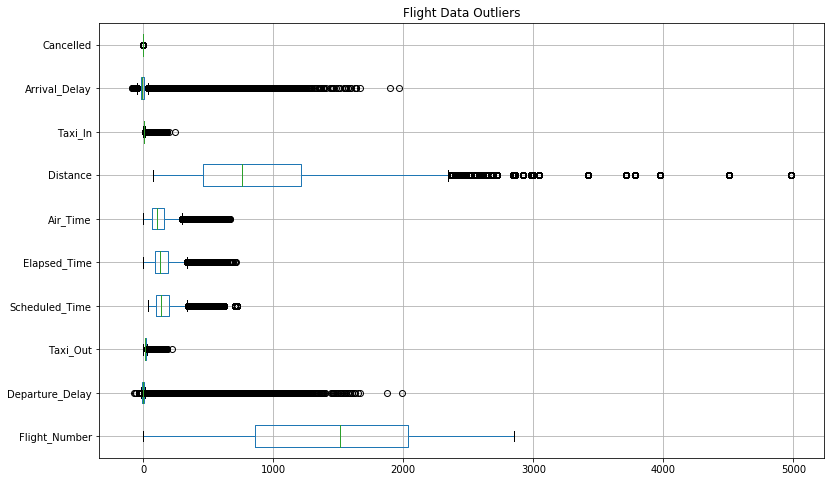

In [72]:
flights.boxplot(figsize=(13,8), vert=False)
plt.title('Flight Data Outliers')
plt.show()

There are some wild outliers in this data. I'll detect exactly where those outliers are by calculating a z-score for each feature, and eliminating rows that contain values with z-scores higher than a threshold of 3 (that is, any values than are more than three standard deviations away from the mean).

In [73]:
# check to see which features are numerical
# Don't include Flight_Number and Cancelled among numerical feats 

flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1789186 entries, 0 to 1800579
Data columns (total 23 columns):
Airline                object
Flight_Number          float64
Tail_Number            object
Origin_Airport         object
Destination_Airport    object
Scheduled_Departure    object
Departure_Time         object
Departure_Delay        float64
Taxi_Out               float64
Wheels_Off             object
Scheduled_Time         float64
Elapsed_Time           float64
Air_Time               float64
Distance               float64
Wheels_On              object
Taxi_In                float64
Scheduled_Arrival      object
Arrival_Time           object
Arrival_Delay          float64
Cancelled              float64
Cancellation_Reason    object
Date                   datetime64[ns]
Weekday                category
dtypes: category(1), datetime64[ns](1), float64(10), object(11)
memory usage: 395.7+ MB


In [74]:
# subset continuous features
flights_num_feats = flights[['Departure_Delay','Taxi_Out','Scheduled_Time',
                             'Elapsed_Time','Air_Time','Distance',
                             'Taxi_In','Arrival_Delay',
                             ]]

In [75]:
# calculate z-score and remove all rows where there are scores higher than 3
z = np.abs(stats.zscore(flights_num_feats))
flights_z = flights_num_feats[(z < 3).all(axis=1)]

In [76]:
print(f"Length of data prior to removing outliers: {len(flights)}")
print(f"Length of data after removing outliers: {len(flights_z)}",'\n')
print(f"Number of rows removed: {len(flights) - len(flights_z)}")

Length of data prior to removing outliers: 1789186
Length of data after removing outliers: 1680231 

Number of rows removed: 108955


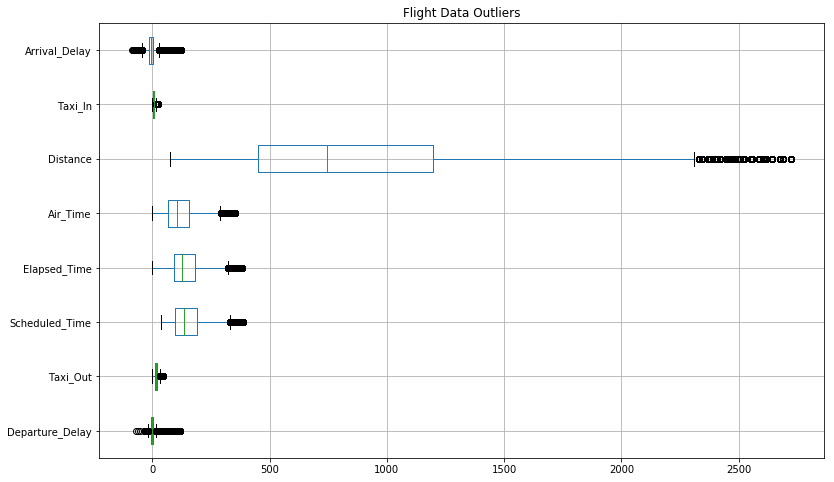

In [77]:
# See updated boxplots
flights_z.boxplot(figsize=(13,8), vert=False)
plt.title('Flight Data Outliers')
plt.show()

That's more like it! Outliers still exist, but there are now fewer of them; the most extreme ones have been eliminated. (Over 100K rows were removed!) Now I'll update my original DataFrame to reflect these changes, by dropping the numerical columns from my original DataFrame, and performing an inner join with the new outlier-free DataFrame.

In [78]:
flights.drop(['Departure_Delay','Taxi_Out','Scheduled_Time','Elapsed_Time',
              'Air_Time','Distance','Taxi_In','Arrival_Delay'], axis=1,
              inplace=True)

flights = flights.join(flights_z, how='inner')

In [79]:
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay
0,AA,2336.0,N3KUAA,LAX,PBI,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,0.0,E,2015-01-01,4.0,-8.0,12.0,280.0,279.0,263.0,2330.0,4.0,-9.0
1,US,840.0,N171US,SFO,CLT,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,0.0,E,2015-01-01,4.0,-2.0,16.0,286.0,293.0,266.0,2296.0,11.0,5.0
2,AA,258.0,N3HYAA,LAX,MIA,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,0.0,E,2015-01-01,4.0,-5.0,15.0,285.0,281.0,258.0,2342.0,8.0,-9.0
3,DL,806.0,N3730B,SFO,MSP,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,0.0,E,2015-01-01,4.0,-5.0,18.0,217.0,230.0,206.0,1589.0,6.0,8.0
4,US,2013.0,N584UW,LAX,CLT,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,0.0,E,2015-01-01,4.0,14.0,13.0,273.0,249.0,228.0,2125.0,8.0,-10.0


Fantastic. Just a couple more loose ends to tie up.

It looks like all the numerical columns have been converted along the way to floats, but I'd like them to be ints, for the sake of simplicity. (Nothing follows the dots in any of those features anyway.)

In [80]:
# This time include `Cancelled`, `Flight_Number`, and `Weekday`
flights_num_feats = flights[['Departure_Delay','Taxi_Out','Scheduled_Time',
                             'Elapsed_Time','Air_Time','Distance',
                             'Taxi_In','Arrival_Delay','Cancelled',
                             'Flight_Number','Weekday']]

for col in flights_num_feats:
    # convert values to ints
    flights[col] = flights[col].astype('int')

# convert Weekday back to category
flights['Weekday'] = flights['Weekday'].astype('category')

In [81]:
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay
0,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,0,E,2015-01-01,4,-8,12,280,279,263,2330,4,-9
1,US,840,N171US,SFO,CLT,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,0,E,2015-01-01,4,-2,16,286,293,266,2296,11,5
2,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,0,E,2015-01-01,4,-5,15,285,281,258,2342,8,-9
3,DL,806,N3730B,SFO,MSP,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,0,E,2015-01-01,4,-5,18,217,230,206,1589,6,8
4,US,2013,N584UW,LAX,CLT,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,0,E,2015-01-01,4,14,13,273,249,228,2125,8,-10


Now that missing values, extraneous values, and outliers are taken care of, I just have a few more things to check for.

First things first: Duplicate data:

In [82]:
duplicates = flights[flights.duplicated()]
print(len(duplicates))
duplicates.head()

0


,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay


Fantastic! Nothing to worry about there.

The next thing I want to do is transform my categorical data through one-hot encoding. Generally, this involves converting each unique category into a new column, and assigning a 1 or 0 to the column. This way my models will be able to handle the data.

The categorical features that will need this kind of engineering are:

- `Airline`
- `Flight_Number`
- `Tail_Number`
- `Origin_Airport`
- `Destination_Airport`
- `Cancellation_Reason`
- `Weekday`

This is a fairly simple procedure for those columns that only have a few unique values, like `Weekday` and `Airline`. But some of these features have literally hundreds—even thousands—of unique values:

In [83]:
print(f"Unique values in 'Airline': {flights['Airline'].nunique()}")
print(f"Unique values in 'Flight_Number': {flights['Flight_Number'].nunique()}")
print(f"Unique values in 'Tail_Number': {flights['Tail_Number'].nunique()}")
print(f"Unique values in 'Origin_Airport': {flights['Origin_Airport'].nunique()}")
print(f"Unique values in 'Destination_Airport': {flights['Destination_Airport'].nunique()}")
print(f"Unique values in 'Cancellation_Reason': {flights['Cancellation_Reason'].nunique()}")
print(f"Unique values in 'Weekday': {flights['Weekday'].nunique()}")

Unique values in 'Airline': 3
Unique values in 'Flight_Number': 2765
Unique values in 'Tail_Number': 1876
Unique values in 'Origin_Airport': 456
Unique values in 'Destination_Airport': 457
Unique values in 'Cancellation_Reason': 5
Unique values in 'Weekday': 7


In [84]:
# save copy of data
copy1 = flights.copy()

I'll start with the easy ones.

In [85]:
# apply dummy coding scheme on 'Airline'
# drop_last instead of drop_first
airline_onehot_features = pd.get_dummies(flights['Airline'])
airline_dummy_features = airline_onehot_features.iloc[:,:-1]

# apply dummy coding scheme on 'Cancellation_Reason'
# drop_last instead of drop_first
cancel_reason_onehot_features = pd.get_dummies(flights['Cancellation_Reason'])
cancel_reason_dummy_features = cancel_reason_onehot_features.iloc[:,:-1]

# apply dummy coding scheme on 'Weekday'
weekday_dummy_features = pd.get_dummies(flights['Weekday'], drop_first=True)

# Tack new binary features onto flights df
flights = pd.concat([flights, airline_dummy_features, weekday_dummy_features,
                      cancel_reason_dummy_features], axis=1)

# Drop original columns
flights.drop(['Airline', 'Cancellation_Reason', 'Weekday'], axis = 1)

# Sanity check
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,AA,DL,2,3,4,5,6,7,A,B,C,D
0,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,0,E,2015-01-01,4,-8,12,280,279,263,2330,4,-9,1,0,0,0,1,0,0,0,0,0,0,0
1,US,840,N171US,SFO,CLT,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,0,E,2015-01-01,4,-2,16,286,293,266,2296,11,5,0,0,0,0,1,0,0,0,0,0,0,0
2,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,0,E,2015-01-01,4,-5,15,285,281,258,2342,8,-9,1,0,0,0,1,0,0,0,0,0,0,0
3,DL,806,N3730B,SFO,MSP,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,0,E,2015-01-01,4,-5,18,217,230,206,1589,6,8,0,1,0,0,1,0,0,0,0,0,0,0
4,US,2013,N584UW,LAX,CLT,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,0,E,2015-01-01,4,14,13,273,249,228,2125,8,-10,0,0,0,0,1,0,0,0,0,0,0,0


That worked out well. Now, I'll stop to save a copy of my data (just in case), and rename these new columns so that they're more descriptive.

In [86]:
# save copy of df
copy2 = flights.copy()

In [87]:
# Rename columns

flights.rename(columns={'DL':'Airline_DL', 'AA':'Airline_AA', 2:'Tuesday',
                         3:'Wednesday', 4:'Thursday', 5:'Friday',
                         6:'Saturday', 7:'Sunday', 'A':'Canceled_A',
                        'B':'Canceled_B', 'C':'Canceled_C',
                        'D':'Canceled_D'}, inplace = True)

In [88]:
# check for the new names
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Airline_AA,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D
0,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,0,E,2015-01-01,4,-8,12,280,279,263,2330,4,-9,1,0,0,0,1,0,0,0,0,0,0,0
1,US,840,N171US,SFO,CLT,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,0,E,2015-01-01,4,-2,16,286,293,266,2296,11,5,0,0,0,0,1,0,0,0,0,0,0,0
2,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,0,E,2015-01-01,4,-5,15,285,281,258,2342,8,-9,1,0,0,0,1,0,0,0,0,0,0,0
3,DL,806,N3730B,SFO,MSP,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,0,E,2015-01-01,4,-5,18,217,230,206,1589,6,8,0,1,0,0,1,0,0,0,0,0,0,0
4,US,2013,N584UW,LAX,CLT,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,0,E,2015-01-01,4,14,13,273,249,228,2125,8,-10,0,0,0,0,1,0,0,0,0,0,0,0


In [89]:
# save copy of df
copy3 = flights.copy()

There are four remaining columns of categorical data, all of which are much larger in scale than the three that I just encoded. To attempt to encode these columns in the same manner would be problematic and impractical, since it would result in my DataFrame acquiring thousands of new columns, sucking up time, space and memory. When the number of distinct categories in any feature becomes very large, there are alternative ways of handling it.

One of those approaches is known as feature-hashing, which is useful when it comes to dealing with large-scaled categorical features like what I have in `Flight_Number`, `Origin_Airport`, `Destination_Airport` and `Tail_Number`. Practically speaking, a hash function maps a large number of values into a small finite set of values. More can be read about it [here](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63).

In [90]:
# reset index so that it aligns with arrays that it'll be
# concatenated with in the next steps

flights.reset_index(drop=True, inplace=True)

In [91]:
# save copy of df
copy4 = flights.copy()

In [92]:
# use feature hashing scheme on 'Tail_Number'
fh1 = FeatureHasher(n_features=9, input_type='string')
hashed_features_tail = fh1.fit_transform(flights['Tail_Number'])
hashed_features_tail = hashed_features_tail.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_tail)], axis=1)

# rename columns
flights.rename(columns={0:'TailId_1', 1:'TailId_2', 2:'TailId_3',
                        3:'TailId_4', 4:'TailId_5', 5:'TailId_6',
                        6:'TailId_7', 7:'TailId_8', 8:'TailId_9'
                        }, inplace = True)

In [93]:
# use feature hashing scheme on 'Flight_Number'
flights['Flight_Number'] = flights.Flight_Number.astype('str')

fh2 = FeatureHasher(n_features=5, input_type='string')
hashed_features_flight = fh2.fit_transform(flights['Flight_Number'])
hashed_features_flight = hashed_features_flight.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_flight)], axis=1)

# rename columns
flights.rename(columns={0:'FlightId_1', 1:'FlightId_2', 2:'FlightId_3',
                        3:'FlightId_4', 4:'FlightId_5', 5:'FlightId_6',
                        6:'FlightId_7'
                        }, inplace = True)

In [94]:
# use feature hashing scheme on 'Origin_Airport'
flights['Origin_Airport'] = flights.Origin_Airport.astype('str')

fh3 = FeatureHasher(n_features=7, input_type='string')
hashed_features_origin = fh3.fit_transform(flights['Origin_Airport'])
hashed_features_origin = hashed_features_origin.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_origin)], axis=1)

# rename columns
flights.rename(columns={0:'Origin_Airport_1', 1:'Origin_Airport_2',
                        2:'Origin_Airport_3', 3:'Origin_Airport_4',
                        4:'Origin_Airport_5', 5:'Origin_Airport_6',
                        6:'Origin_Airport_7', 7:'Origin_Airport_8'},
                        inplace = True)

In [95]:
# use feature hashing scheme on 'Destination_Airport'
flights['Destination_Airport'] = flights.Destination_Airport.astype('str')

fh4 = FeatureHasher(n_features=7, input_type='string')
hashed_features_dest = fh4.fit_transform(flights['Destination_Airport'])
hashed_features_dest = hashed_features_dest.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_dest)], axis=1)

# rename columns
flights.rename(columns={0:'Dest_Airport_1', 1:'Dest_Airport_2',
                        2:'Dest_Airport_3', 3:'Dest_Airport_4',
                        4:'Dest_Airport_5', 5:'Dest_Airport_6',
                        6:'Dest_Airport_7', 7:'Dest_Airport_8'},
                        inplace = True)

In [96]:
# check preview of updated features
flights.head()

,Airline,Flight_Number,Tail_Number,Origin_Airport,Destination_Airport,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Cancelled,Cancellation_Reason,Date,Weekday,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Airline_AA,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7
0,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,0,E,2015-01-01,4,-8,12,280,279,263,2330,4,-9,1,0,0,0,1,0,0,0,0,0,0,0,1.0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,US,840,N171US,SFO,CLT,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,0,E,2015-01-01,4,-2,16,286,293,266,2296,11,5,0,0,0,0,1,0,0,0,0,0,0,0,-1.0,-2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0
2,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,0,E,2015-01-01,4,-5,15,285,281,258,2342,8,-9,1,0,0,0,1,0,0,0,0,0,0,0,1.0,3.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,DL,806,N3730B,SFO,MSP,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,0,E,2015-01-01,4,-5,18,217,230,206,1589,6,8,0,1,0,0,1,0,0,0,0,0,0,0,2.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,0.0
4,US,2013,N584UW,LAX,CLT,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,0,E,2015-01-01,4,14,13,273,249,228,2125,8,-10,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0


With this phase of my feature engineering complete, it's time to say goodbye to those original categorical features.

In [97]:
flights.drop(columns=['Airline', 'Flight_Number', 'Tail_Number',
                      'Origin_Airport', 'Destination_Airport', 'Weekday',
                      'Cancellation_Reason'], inplace=True)

In [98]:
# make sure columns dropped as expected
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680231 entries, 0 to 1680230
Data columns (total 56 columns):
Scheduled_Departure    1680231 non-null object
Departure_Time         1680231 non-null object
Wheels_Off             1680231 non-null object
Wheels_On              1680231 non-null object
Scheduled_Arrival      1680231 non-null object
Arrival_Time           1680231 non-null object
Cancelled              1680231 non-null int64
Date                   1680231 non-null datetime64[ns]
Departure_Delay        1680231 non-null int64
Taxi_Out               1680231 non-null int64
Scheduled_Time         1680231 non-null int64
Elapsed_Time           1680231 non-null int64
Air_Time               1680231 non-null int64
Distance               1680231 non-null int64
Taxi_In                1680231 non-null int64
Arrival_Delay          1680231 non-null int64
Airline_AA             1680231 non-null uint8
Airline_DL             1680231 non-null uint8
Tuesday                1680231 non-null uint

In [99]:
# save copy of data
copy5 = flights.copy()

## 3. Explore
#### Understand the data. Find significant patterns and trends using statistical methods.

I've done quite a lot of exploring already, during the data scrubbing phase. But there are still a few stones left to turn...

At this point, as I get closer to modeling, I want to create a target variable that will indicate if a plane was at least 5-minutes delayed or canceled. That is what I'm eventually going to be trying to predict, or classify. This will be a binary features, and I'll call it `Delayed_Canceled`.

In [100]:
# Create new binary feature indicating whether a flight was delayed by 5 minutes or more
flights['Delayed'] = flights['Departure_Delay'].apply(lambda x: 'Delayed' if x >= 5 else 'Not Delayed')
flights['Delayed'] = flights['Delayed'].map({'Delayed':1, 'Not Delayed':0})

# Sum 5-min-or-more-delayed flights and canceled flights
flights['Delayed_Canceled'] = flights['Delayed'] + flights['Cancelled']

# Drop columns
flights.drop(columns=['Delayed','Cancelled'], axis=1, inplace=True)

In [101]:
# check it see if the new column arrived, and the other two are now removed
flights.head()

,Scheduled_Departure,Departure_Time,Wheels_Off,Wheels_On,Scheduled_Arrival,Arrival_Time,Date,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Airline_AA,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled
0,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,2015-01-01,-8,12,280,279,263,2330,4,-9,1,0,0,0,1,0,0,0,0,0,0,0,1.0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0
1,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,2015-01-01,-2,16,286,293,266,2296,11,5,0,0,0,0,1,0,0,0,0,0,0,0,-1.0,-2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0
2,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,2015-01-01,-5,15,285,281,258,2342,8,-9,1,0,0,0,1,0,0,0,0,0,0,0,1.0,3.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0
3,00:25:00,00:20:00,00:38:00,06:04:00,06:02:00,06:10:00,2015-01-01,-5,18,217,230,206,1589,6,8,0,1,0,0,1,0,0,0,0,0,0,0,2.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,0.0,0
4,00:30:00,00:44:00,00:57:00,07:45:00,08:03:00,07:53:00,2015-01-01,14,13,273,249,228,2125,8,-10,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,1


It'd be nice to know the frequency with with planes depart on-time. Allow me to visualize it, and then grab an exact percentage.

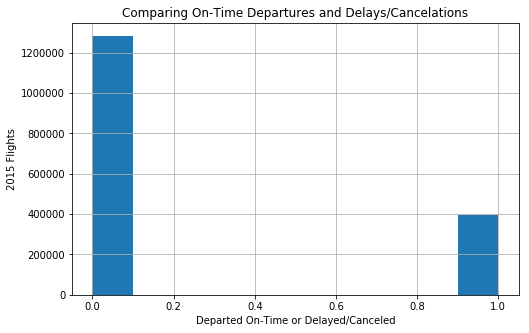

In [102]:
flights.hist(column= ['Delayed_Canceled'], figsize  = [8, 5]);
plt.title('Comparing On-Time Departures and Delays/Cancelations')
plt.xlabel('Departed On-Time or Delayed/Canceled')
plt.ylabel('2015 Flights')
plt.show()

In [103]:
flights['Delayed_Canceled'].value_counts(normalize=True)

0    0.763607
1    0.236393
Name: Delayed_Canceled, dtype: float64

76% of flights in 2015 (from the three airlines I'm studying) left on-time, while 24% departed at least 5-minutes behind schedule or were canceled.

In [107]:
# save copy of data
copy6 = flights.copy()

Next, I'll begin checking for multicollinearity. To get an idea of how my independent (or predictor) variables might relate to each other. I'm going to make a correlation matrix that returns pairwise correlations between all features.

In [108]:
# See how the variables correlate
flights.corr()

,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Airline_AA,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled
Departure_Delay,1.000000,0.046405,0.029596,0.027251,0.025197,0.023711,-0.031509,0.842896,0.026349,-0.020437,-0.012864,-0.010175,0.013709,0.007598,-0.014186,0.001315,-0.008251,-0.015922,-0.003975,-0.000340,0.001507,0.030273,-0.011850,-0.000235,0.000824,0.012474,0.003519,0.008844,-0.012538,0.003456,0.004194,0.004831,0.003668,0.003703,-0.026383,0.002841,-0.021266,0.005178,0.007332,0.041392,0.029469,0.016782,-0.010998,-0.015732,0.023286,0.025721,-0.013837,0.040317,0.714673
Taxi_Out,0.046405,1.000000,0.104499,0.205078,0.112520,0.069892,0.012263,0.258893,-0.009597,-0.021993,0.004733,0.017886,0.024177,0.011804,-0.040784,-0.023225,-0.092440,-0.178386,-0.044534,-0.003811,-0.020041,-0.048232,0.027400,0.009999,-0.000953,0.010642,-0.003163,-0.048818,0.004037,-0.015187,-0.007878,0.011755,0.005156,0.002404,-0.043791,0.062471,-0.047091,0.044993,0.058850,-0.014483,-0.005188,0.036355,-0.009599,-0.000370,0.026254,0.028951,-0.037064,0.026939,0.022974
Scheduled_Time,0.029596,0.104499,1.000000,0.970568,0.977007,0.982876,0.095246,-0.063608,0.147432,-0.133929,-0.012131,-0.008690,-0.003605,-0.004231,0.024535,0.010383,0.005777,-0.000429,-0.000785,-0.001855,0.053886,0.144365,-0.154983,-0.024456,0.035086,0.016130,0.067512,0.051809,0.006237,-0.029575,-0.049952,0.025602,0.001945,-0.000456,0.128683,0.067279,-0.012525,-0.004594,-0.006538,-0.028749,0.032314,0.132883,0.079652,-0.015503,-0.011006,-0.037871,-0.037484,0.025329,0.041382
Elapsed_Time,0.027251,0.205078,0.970568,1.000000,0.994024,0.960746,0.154123,0.013151,0.141970,-0.141330,-0.010773,-0.005238,0.001156,-0.001434,0.019922,0.004332,-0.075905,-0.146477,-0.036568,-0.003129,0.045567,0.131149,-0.151521,-0.021674,0.032248,0.007349,0.070521,0.035918,0.010949,-0.030711,-0.051216,0.027114,0.001959,-0.001527,0.130541,0.057911,-0.011836,-0.003876,-0.013087,-0.038267,0.029848,0.135820,0.070487,-0.015267,-0.012243,-0.035416,-0.040601,0.024034,0.011694
Air_Time,0.025197,0.112520,0.977007,0.994024,1.000000,0.971551,0.099087,-0.016208,0.138122,-0.135183,-0.011475,-0.007050,-0.001308,-0.002975,0.025002,0.006571,-0.064803,-0.125054,-0.031220,-0.002672,0.048898,0.131673,-0.154253,-0.023044,0.031872,0.004864,0.072231,0.040713,0.012187,-0.029519,-0.050907,0.027431,0.001517,-0.001967,0.131278,0.054788,-0.009645,-0.007992,-0.020428,-0.034959,0.029842,0.141186,0.066192,-0.013137,-0.012847,-0.036118,-0.048691,0.020668,0.013114
Distance,0.023711,0.069892,0.982876,0.960746,0.971551,1.000000,0.073476,-0.046584,0.138111,-0.126872,-0.013263,-0.009706,-0.003611,-0.004279,0.027745,0.010169,0.004565,-0.003632,-0.002717,-0.001845,0.050843,0.135818,-0.157069,-0.024250,0.032172,0.010339,0.071948,0.049740,0.013897,-0.033414,-0.050241,0.026561,-0.005459,-0.006015,0.145977,0.066473,-0.011319,0.000967,-0.031679,-0.050087,0.027787,0.131345,0.064178,-0.010615,-0.013507,-0.031406,-0.043695,0.021721,0.036088
Taxi_In,-0.031509,0.012263,0.095246,0.154123,0.099087,0.073476,1.000000,0.081493,0.139332,-0.126009,0.000008,-0.000568,0.002740,0.006437,-0.012080,0.001753,-0.068018,-0.131257,-0.032768,-0.002804,-0.006365,0.123836,-0.058313,-0.001487,0.020888,0.028328,0.003357,0.012723,-0.024047,-0.007371,-0.012376,-0.014597,-0.000201,0.003028,0.112409,-0.027793,0.036354,-0.005470,0.023813,-0.048429,0.020626,-0.101103,0.118884,-0.042550,-0.038492,-0.050470,0.187400,0.022858,-0.058793
Arrival_Delay,0.842896,0.258893,-0.063608,0.013151,-0.016208,-0.046584,0.081493,1.000000,0.03625

It looks like some of the heavier correlations are located in the top-left corner of the matrix, where the time-duration features are clustered together. Let's take a look on a heatmap.

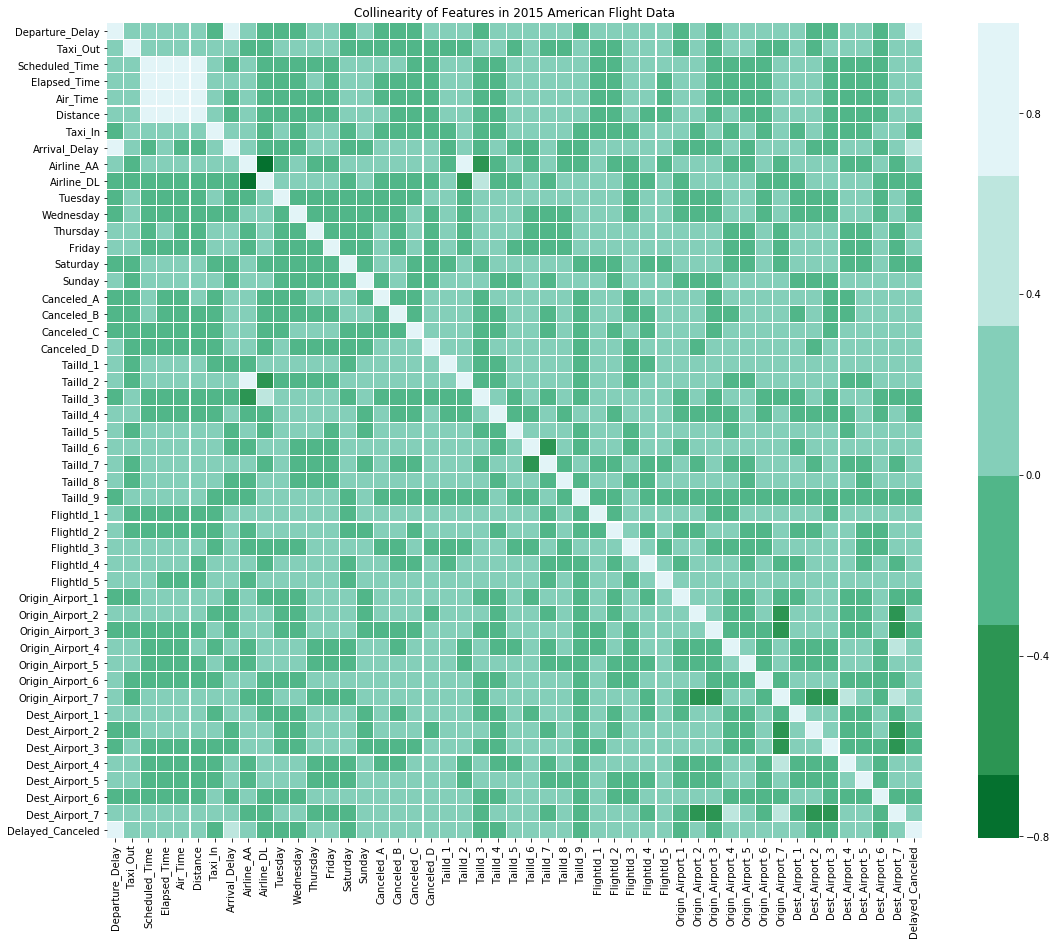

In [109]:
plt.figure(figsize=(20,15))
plt.title('Collinearity of Features in 2015 American Flight Data')
sns.heatmap(flights.corr(), center=0, square=True, linewidths=.1,
            cmap = sns.color_palette("BuGn_r"));

The heatmap reflects this, of course. I'll filter for correlations of greater than 0.75 and lower than -0.75, and remove one feature from any of those especially strong correlation pairs.

In [110]:
abs(flights.corr()) > 0.75

,Departure_Delay,Taxi_Out,Scheduled_Time,Elapsed_Time,Air_Time,Distance,Taxi_In,Arrival_Delay,Airline_AA,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled
Departure_Delay,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Taxi_Out,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Scheduled_Time,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Elapsed_Time,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Air_Time,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Distance,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Taxi_In,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Arrival_Delay,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Airline_AA,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Airline_DL,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


The most highly correlated pairs of features are:

- `Departure_Delay` & `Arrival_Delay`: 0.842896
- `Airline_AA` & `Airline_DL`: -0.803821
- `Scheduled_Time` & `Elapsed_Time`: 0.970568
- `Scheduled_Time` & `Air_Time`: 0.977007
- `Scheduled_Time` & `Distance`: 0.982876
- `Elapsed_Time` & `Air_Time`: 0.994024
- `Elapsed_Time` & `Distance`: 0.960746
- `Air_Time` & `Distance`: 0.971551

I'll drop one column from each of the first pairs listed. As for the rest of the pairs, I think dropping three of those columns should be enough to untangle that web.

In [111]:
flights.drop(['Departure_Delay', 'Air_Time', 'Elapsed_Time',
              'Distance', 'Airline_AA'], axis=1, inplace=True)

In [112]:
copy7 = flights.copy()

*Due to unforeseen complications down in the modeling phase, I'm returning to this point so that I can try feature-hashing my time-point columns.*

In [113]:
# use feature hashing scheme on 'Arrival_Time'
flights['Arrival_Time'] = flights.Arrival_Time.astype('str')

fh5 = FeatureHasher(n_features=5, input_type='string')
hashed_features_arrival = fh5.fit_transform(flights['Arrival_Time'])
hashed_features_arrival = hashed_features_arrival.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_arrival)], axis=1)

# rename columns
flights.rename(columns={0:'Arrival_Time_1', 1:'Arrival_Time_2',
                        2:'Arrival_Time_3', 3:'Arrival_Time_4',
                        4:'Arrival_Time_5', 5:'Arrival_Time_6',
                        6:'Arrival_Time_7', 7:'Arrival_Time_8'
                        },
                        inplace = True)

In [114]:
# use feature hashing scheme on 'Departure_Time'
flights['Departure_Time'] = flights.Departure_Time.astype('str')

fh6 = FeatureHasher(n_features=5, input_type='string')
hashed_features_depart = fh6.fit_transform(flights['Departure_Time'])
hashed_features_depart = hashed_features_depart.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_depart)], axis=1)

# rename columns
flights.rename(columns={0:'Depart_Time_1', 1:'Depart_Time_2',
                        2:'Depart_Time_3', 3:'Depart_Time_4',
                        4:'Depart_Time_5', 5:'Depart_Time_6',
                        6:'Depart_Time_7', 7:'Depart_Time_8',
                        8:'Depart_Time_9', 9:'Depart_Time_10'},
                        inplace = True)

In [115]:
# use feature hashing scheme on 'Scheduled_Departure'
flights['Scheduled_Departure'] = flights.Scheduled_Departure.astype('str')

fh7 = FeatureHasher(n_features=5, input_type='string')
hashed_features_schdepart = fh7.fit_transform(flights['Scheduled_Departure'])
hashed_features_schdepart = hashed_features_schdepart.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_schdepart)],
                    axis=1)

# rename columns
flights.rename(columns={0:'Sched_Depart_Time_1', 1:'Sched_Depart_Time_2',
                        2:'Sched_Depart_Time_3', 3:'Sched_Depart_Time_4',
                        4:'Sched_Depart_Time_5', 5:'Sched_Depart_Time_6',
                        6:'Sched_Depart_Time_7', 7:'Sched_Depart_Time_8',
                        8:'Sched_Depart_Time_9', 9:'Sched_Depart_Time_10'},
                        inplace = True)

In [116]:
# use feature hashing scheme on 'Scheduled_Arrival'
flights['Scheduled_Arrival'] = flights.Scheduled_Arrival.astype('str')

fh8 = FeatureHasher(n_features=5, input_type='string')
hashed_features_scharrive = fh8.fit_transform(flights['Scheduled_Arrival'])
hashed_features_scharrive = hashed_features_scharrive.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_scharrive)],
                    axis=1)

# rename columns
flights.rename(columns={0:'Sched_Arrive_Time_1', 1:'Sched_Arrive_Time_2',
                        2:'Sched_Arrive_Time_3', 3:'Sched_Arrive_Time_4',
                        4:'Sched_Arrive_Time_5', 5:'Sched_Arrive_Time_6',
                        6:'Sched_Arrive_Time_7', 7:'Sched_Arrive_Time_8',
                        8:'Sched_Arrive_Time_9', 9:'Sched_Arrive_Time_10'},
                        inplace = True)

In [117]:
# use feature hashing scheme on 'Wheels_On'
flights['Wheels_On'] = flights.Wheels_On.astype('str')

fh9 = FeatureHasher(n_features=5, input_type='string')
hashed_features_wheelson = fh9.fit_transform(flights['Wheels_On'])
hashed_features_wheelson = hashed_features_wheelson.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_wheelson)],
                    axis=1)

# rename columns
flights.rename(columns={0:'Wheels_On_1', 1:'Wheels_On_2',
                        2:'Wheels_On_3', 3:'Wheels_On_4',
                        4:'Wheels_On_5', 5:'Wheels_On_6',
                        6:'Wheels_On_7', 7:'Wheels_On_8',
                        8:'Wheels_On_9', 9:'Wheels_On_10'},
                        inplace = True)

In [118]:
# use feature hashing scheme on 'Wheels_Off'
flights['Wheels_Off'] = flights.Wheels_Off.astype('str')

fh10 = FeatureHasher(n_features=5, input_type='string')
hashed_features_wheelsoff = fh10.fit_transform(flights['Wheels_Off'])
hashed_features_wheelsoff = hashed_features_wheelsoff.toarray()

# bring transformed data together
flights = pd.concat([flights, pd.DataFrame(hashed_features_wheelsoff)],
                    axis=1)

# rename columns
flights.rename(columns={0:'Wheels_Off_1', 1:'Wheels_Off_2',
                        2:'Wheels_Off_3', 3:'Wheels_Off_4',
                        4:'Wheels_Off_5', 5:'Wheels_Off_6',
                        6:'Wheels_Off_7', 7:'Wheels_Off_8',
                        8:'Wheels_Off_9', 9:'Wheels_Off_10'},
                        inplace = True)

In [120]:
#check for multicollinearity
flights.corr() > .75

,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5
Taxi_Out,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Scheduled_Time,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Taxi_In,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Arrival_Delay,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Airline_DL,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Tuesday,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Wednesday,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [121]:
# drop original time-point columns
flights.drop(columns=['Scheduled_Departure', 'Scheduled_Arrival',
                     'Arrival_Time', 'Departure_Time',
                     'Wheels_On', 'Wheels_Off'], axis=1, inplace=True)

In [122]:
copy8 = flights.copy()

In [123]:
flights.head()

,Date,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5
0,2015-01-01,12,280,4,-9,0,0,0,1,0,0,0,0,0,0,0,1.0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0,2.0,0.0,-2.0,1.0,-3.0,2.0,1.0,0.0,0.0,-5.0,2.0,0.0,-1.0,0.0,-5.0,3.0,0.0,0.0,1.0,-4.0,3.0,0.0,0.0,2.0,-3.0,2.0,0.0,-2.0,0.0,-4.0
1,2015-01-01,16,286,11,5,0,0,0,1,0,0,0,0,0,0,0,-1.0,-2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0,2.0,0.0,-2.0,-1.0,-3.0,2.0,0.0,-1.0,-1.0,-4.0,2.0,1.0,0.0,0.0,-5.0,3.0,0.0,0.0,-1.0,-4.0,2.0,0.0,0.0,-1.0,-5.0,3.0,0.0,-1.0,0.0,-4.0
2,2015-01-01,15,285,8,-9,0,0,0,1,0,0,0,0,0,0,0,1.0,3.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,4.0,0.0,0.0,1.0,-3.0,3.0,0.0,-1.0,0.0,-4.0,2.0,1.0,0.0,0.0,-5.0,3.0,0.0,0.0,-1.0,-4.0,2.0,0.0,-1.0,0.0,-3.0,3.0,0.0,0.0,0.0,-5.0
3,2015-01-01,18,217,6,8,1,0,0,1,0,0,0,0,0,0,0,2.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,0.0,0,3.0,0.0,-1.0,0.0,-4.0,2.0,1.0,0.0,0.0,-5.0,3.0,1.0,0.0,0.0,-4.0,3.0,1.0,0.0,0.0,-4.0,3.0,0.0,-1.0,0.0,-4.0,3.0,0.0,0.0,-1.0,-4.0
4,2015-01-01,13,273,8,-10,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,1,4.0,0.0,0.0,1.0,-3.0,2.0,0.0,-2.0,0.0,-4.0,3.0,0.0,0.0,0.0,-5.0,3.0,0.0,0.0,-1.0,-4.0,3.0,0.0,-1.0,1.0,-3.0,3.0,0.0,0.0,1.0,-4.0


## 4. Model
#### Construct models to predict and forecast

*Early attempts at fitting a model proved to come with excessively long execution times. So, for the sake of cutting down those long waits, I'm going to make the unexpected and unplanned step of picking out a random sample of July flights, which will still leave me with enough rows of data to meet the project requirements.*

In [124]:
# subset for July flights

flights['Date'] = pd.to_datetime(flights['Date'])
flights = flights[flights['Date'].dt.month == 7]

In [125]:
# collect sample for model
flights = flights.sample(n=50000, random_state=45)

In [126]:
# sanity check
len(flights)

50000

In [127]:
# apply dummy coding scheme on 'Date'
flights['Date'] = flights.Date.astype('str')
date_dummy_features = pd.get_dummies(flights['Date'], drop_first=True)

# # Tack new binary features onto flights df
flights = pd.concat([flights, date_dummy_features], axis=1)

In [128]:
# get all the indices in neat order as we head into modeling
flights.reset_index(drop=True, inplace=True)

In [129]:
# drop original 'Date' column
flights.drop('Date', axis=1, inplace=True)

In [131]:
# view summary stats
flights.describe()

,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,Canceled_D,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,16.983540,156.842920,7.393020,-2.574260,0.504840,0.132240,0.163320,0.165000,0.164740,0.108780,0.131020,0.001340,0.000400,0.000400,0.0,0.627240,0.451040,0.560680,0.061520,0.019760,-1.388280,-0.134320,-0.370820,0.242200,0.918060,0.861040,-1.064520,-0.001240,-0.263160,-0.704500,-0.258540,0.141360,0.240740,0.047940,0.095440,0.118000,-0.718580,-0.257780,0.138200,0.239000,0.048980,0.091520,0.116460,0.254460,2.875180,0.805340,-1.298600,-0.025360,-2.603840,2.930960,0.694640,-1.215480,0.01702,-2.69558,2.98258,0.554680,-1.087000,0.026080,-3.060340,2.885880,0.805680,-1.292120,-0.039120,-2.643840,2.882880,0.797280,-1.290580,-0.025060,-2.602840,2.854060,0.727400,-1.262040,0.028560,-2.682660,0.033120,0.026960,0.025000,0.032880,0.033600,0.03398,0.031580,0.03276,0.033960,0.029980,0.033020,0.032480,0.031460,0.032840,0.033620,0.03534,0.025840,0.03218,0.035540,0.032640,0.033080,0.033020,0.035260,0.02796,0.032940,0.033280,0.034160,0.033700,0.032480,0.033220
std,6.779542,73.188949,4.047059,21.638225,0.499982,0.338755,0.369661,0.371184,0.370949,0.311366,0.337426,0.036582,0.019996,0.019996,0.0,0.752955,1.163473,0.819641,0.738259,0.252608,0.923978,0.399802,0.561034,0.522594,0.786358,0.810051,0.835542,0.759217,0.484016,0.933744,0.473774,0.357519,0.694287,0.260621,0.869061,0.322611,0.929796,0.474736,0.353077,0.690832,0.262873

I notice that `Canceled_D` is loaded with nothing but zeros, so I'll delete that column.

In [132]:
flights.drop('Canceled_D', axis=1, inplace=True)

In [133]:
# save cleaned data as a new csv file so I don't need to execute
# all preceeded cells when re-opening notebook

flights.to_csv('flights_cleaned.csv', index_label=False)

In [2]:
flights = pd.read_csv('flights_cleaned.csv')

In [3]:
flights.head()

,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31
0,19,268,4,0,0,0,0,0,0,1,0,0,0,0,0.0,-1.0,1.0,0.0,0.0,-3.0,0.0,-1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0,3.0,1.0,-2.0,0.0,-2.0,2.0,0.0,-1.0,-2.0,-3.0,2.0,0.0,-2.0,-1.0,-3.0,3.0,1.0,-2.0,0.0,-2.0,3.0,0.0,-1.0,-1.0,-3.0,2.0,1.0,0.0,1.0,-4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13,65,4,-16,1,1,0,0,0,0,0,0,0,0,2.0,-1.0,-1.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,1.0,-3.0,0.0,0.0,-2.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,-1.0,0.0,0,3.0,1.0,-1.0,0.0,-3.0,2.0,0.0,-2.0,1.0,-3.0,2.0,0.0,-3.0,0.0,-3.0,3.0,0.0,-3.0,0.0,-2.0,4.0,0.0,-1.0,0.0,-3.0,2.0,1.0,-2.0,0.0,-3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,21,87,19,1,0,1,0,0,0,0,0,0,0,0,0.0,-1.0,1.0,0.0,0.0,-2.0,0.0,-1.0,1.0,0.0,0.0,-3.0,1.0,0.0,-2.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,-1.0,1.0,-3.0,5.0,0.0,-1.0,0.0,-2.0,5.0,0.0,-1.0,0.0,-2.0,2.0,1.0,-1.0,1.0,-3.0,3.0,0.0,-3.0,0.0,-2.0,4.0,0.0,-2.0,0.0,-2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13,79,10,-7,1,0,0,0,0,1,0,0,0,0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0,3.0,1.0,0.0,1.0,-3.0,3.0,1.0,0.0,1.0,-3.0,3.0,0.0,-1.0,1.0,-3.0,2.0,0.0,-2.0,0.0,-4.0,2.0,1.0,-1.0,1.0,-3.0,3.0,1.0,0.0,1.0,-3.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21,123,6,109,0,0,0,1,0,0,0,0,0,0,1.0,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,3.0,3.0,0.0,0.0,-2.0,4.0,1.0,-1.0,0.0,-2.0,2.0,1.0,0.0,0.0,-5.0,3.0,1.0,-1.0,0.0,-3.0,3.0,2.0,-1.0,0.0,-2.0,2.0,2.0,-2.0,0.0,-2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Now, the focus is wholly on prediction. Having a model that generalizes well and is able to make a good prediction will require a number of steps, including testing the model on unseen data, cross-validation, and regularization. For higher performance, it's best to use more than one type of model, but integrate several into a diverse portfolio. So, for this project, I'm trying out **Logistic Regression**, **Random Forest** and **XGBoost**.

The first step here, before applying any scaling/preprocessing techniques, is to split the data. This is done in order to avoid [data leakage](https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742).

In [6]:
# define dependent (target) and independent (predictor) variables
X = flights.drop(['Delayed_Canceled'], axis = 1)
y = flights['Delayed_Canceled']

# # # split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=99)

In [7]:
# check the range of columns in data
flights.describe()

,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Delayed_Canceled,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,16.983540,156.842920,7.393020,-2.574260,0.504840,0.132240,0.163320,0.165000,0.164740,0.108780,0.131020,0.001340,0.000400,0.000400,0.627240,0.451040,0.560680,0.061520,0.019760,-1.388280,-0.134320,-0.370820,0.242200,0.918060,0.861040,-1.064520,-0.001240,-0.263160,-0.704500,-0.258540,0.141360,0.240740,0.047940,0.095440,0.118000,-0.718580,-0.257780,0.138200,0.239000,0.048980,0.091520,0.116460,0.254460,2.875180,0.805340,-1.298600,-0.025360,-2.603840,2.930960,0.694640,-1.215480,0.01702,-2.69558,2.98258,0.554680,-1.087000,0.026080,-3.060340,2.885880,0.805680,-1.292120,-0.039120,-2.643840,2.882880,0.797280,-1.290580,-0.025060,-2.602840,2.854060,0.727400,-1.262040,0.028560,-2.682660,0.033120,0.026960,0.025000,0.032880,0.033600,0.03398,0.031580,0.03276,0.033960,0.029980,0.033020,0.032480,0.031460,0.032840,0.033620,0.03534,0.025840,0.03218,0.035540,0.032640,0.033080,0.033020,0.035260,0.02796,0.032940,0.033280,0.034160,0.033700,0.032480,0.033220
std,6.779542,73.188949,4.047059,21.638225,0.499982,0.338755,0.369661,0.371184,0.370949,0.311366,0.337426,0.036582,0.019996,0.019996,0.752955,1.163473,0.819641,0.738259,0.252608,0.923978,0.399802,0.561034,0.522594,0.786358,0.810051,0.835542,0.759217,0.484016,0.933744,0.473774,0.357519,0.694287,0.260621,0.869061,0.322611,0.929796,0.474736,0.353077,0.690832,0.262873,0.868216,0.320779,0.435562

Paying close attention to the range (min and max values) of all the columns, I also notice that not all features are on the same scale. If the features are on different scales, some features may impact the model more heavily then others. To level the playing field, it's important to normalize all features to a consistent scale of 0 to 1. That can be done using `StandardScaler()`.

### Pipeline I: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Logistic regression uses a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) which helps to plot an "s"-like curve that enables a linear function to act as a binary classifier.

In [8]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
scaled_df_train.head()

,Taxi_Out,Scheduled_Time,Taxi_In,Arrival_Delay,Airline_DL,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Canceled_A,Canceled_B,Canceled_C,TailId_1,TailId_2,TailId_3,TailId_4,TailId_5,TailId_6,TailId_7,TailId_8,TailId_9,FlightId_1,FlightId_2,FlightId_3,FlightId_4,FlightId_5,Origin_Airport_1,Origin_Airport_2,Origin_Airport_3,Origin_Airport_4,Origin_Airport_5,Origin_Airport_6,Origin_Airport_7,Dest_Airport_1,Dest_Airport_2,Dest_Airport_3,Dest_Airport_4,Dest_Airport_5,Dest_Airport_6,Dest_Airport_7,Arrival_Time_1,Arrival_Time_2,Arrival_Time_3,Arrival_Time_4,Arrival_Time_5,Depart_Time_1,Depart_Time_2,Depart_Time_3,Depart_Time_4,Depart_Time_5,Sched_Depart_Time_1,Sched_Depart_Time_2,Sched_Depart_Time_3,Sched_Depart_Time_4,Sched_Depart_Time_5,Sched_Arrive_Time_1,Sched_Arrive_Time_2,Sched_Arrive_Time_3,Sched_Arrive_Time_4,Sched_Arrive_Time_5,Wheels_On_1,Wheels_On_2,Wheels_On_3,Wheels_On_4,Wheels_On_5,Wheels_Off_1,Wheels_Off_2,Wheels_Off_3,Wheels_Off_4,Wheels_Off_5,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31
0,-1.176636,-0.955805,1.126077,-0.436858,0.991556,2.566415,-0.443430,-0.444506,-0.446312,-0.348345,-0.386601,-0.036903,-0.02066,-0.02066,-0.834435,-0.387426,2.976497,-0.081141,-0.077556,0.422489,0.335122,0.657975,-0.464697,1.372342,0.167083,1.272726,0.001726,0.546852,-0.319142,-1.566024,-0.394925,-0.347986,3.646617,-0.108657,-0.366425,-1.377842,0.543225,-0.392124,1.100627,-0.187485,-0.108731,-0.362763,1.404066,-1.000026,-0.782014,0.040428,0.849434,0.080236,1.723640,0.239422,-0.026501,0.964472,0.017736,-0.790932,0.105052,-0.047732,-1.035438,0.144191,0.245439,0.327553,1.706874,0.911272,1.394587,-0.987682,0.323353,0.038593,-0.572851,0.178894,-0.921503,0.290289,-1.529444,-0.449803,-0.184076,-0.170057,-0.159558,-0.183144,-0.186845,-0.18852,-0.181034,-0.185772,-0.186768,-0.176667,-0.183843,-0.183067,-0.178664,-0.184308,-0.18715,-0.190182,-0.16278,-0.181191,-0.190257,-0.182287,-0.186615,-0.182521,-0.193321,-0.167551,-0.185003,-0.186002,5.298091,-0.186921,-0.184076,-0.185772
1,-1.029309,0.318660,1.863446,-0.622517,-1.008516,-0.389649,2.255147,-0.444506,-0.446312,-0.348345,-0.386601,-0.036903,-0.02066,-0.02066,-0.834435,1.327254,0.537119,-0.081141,-0.077556,-1.739392,0.335122,0.657975,-0.464697,-1.169220,-1.065091,-2.313809,1.322866,0.546852,-0.319142,-1.566024,-0.394925,-0.347986,-0.184292,1.042048,-0.366425,-0.301963,0.543225,-0.392124,-1.789169,-0.187485,1.044381,-0.362763,-1.097120,1.490658,0.333661,0.040428,-0.563464,1.273749,-0.913024,0.239422,-1.520928,0.964472,-1.239527,-0.790932,-1.083316,-1.821730,0.062137,-1.121534,0.245439,0.327553,0.064386,-1.926402,-1.105748,1.495262,1.439799,0.038593,-2.007368,0.178894,-0.921503,-0.814760,-1.529444,0.959001,-0.184076,-0.170057,-0.159558,-0.183144,-0.186845,-0.18852,-0.181034,-0.185772,-0.186768,-0.176667,-0.183843,-0.183067,-0.178664,-0.184308,-0.18715,-0.190182,-0.16278,-0.181191,-0.190257,-0.182287,-0.186615,-0.182521,-0.193321,-0.167551,-0.185003,-0.186002,-0.188747,-0.186921,-0.184076,-0.185772
2,-0.881982,-0.489872,0.880287,-0.251200,-1.008516,-0.389649,-0.443430,-0.444506,-0.446312,-0.348345,2.586645,-0.036903,-0.02066,-0.02066,-0.834435,1.327254,-0.682571,2.634414,-0.077556,0.422489,0.335122,-1.132595,-0.464697,0.101561,0.167083,0.077214,-1.319413,0.546852,-0.319142,0.545203,-0.394925,1.093309,-0.184292,-1.259363,-0.366425,-0.301963,0.543225,-0.392124,-1.789169,-0.187485,1.044381,-0.362763,-1.097120,0.245316,1.449337,-1.543746,-1.976361,-1.113277,-0.913024,-0.863972,1.467926,-0.424884,0.017736,-0.790932,0.105052,1.726266,0.062137,0.144191,0.245439,0.327553,0.064386,-0.507565,0.144419,-0.987682,1.439799,0.038593,-0.572851,0.178894,0.344020,1.395337,1.442658,-0.449803,-0.184076,-0.170057,-0.159558,-0.183144

In [9]:
# Instantiate the model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
logreg.fit(scaled_data_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# Generate predictions
logreg_train_preds = logreg.predict(scaled_data_train)
logreg_test_preds = logreg.predict(scaled_data_test)

In [11]:
# accuracy on training set

residuals = np.abs(y_train - logreg_train_preds)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

# 33243 correct, ~ 88.6% accuracy

0    33243
1     4257
Name: Delayed_Canceled, dtype: int64
------------------------------------
0    0.88648
1    0.11352
Name: Delayed_Canceled, dtype: float64


In [12]:
# accuracy on test set

residuals = np.abs(y_test - logreg_test_preds)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

# 11076 correct, ~ 88.6% accuracy

0    11076
1     1424
Name: Delayed_Canceled, dtype: int64
------------------------------------
0    0.88608
1    0.11392
Name: Delayed_Canceled, dtype: float64


The accuracy score between the training and test sets are almost identical—an indication of a well fit model.

### Pipeline II: [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

A random forest is an ensemble method for decision trees, which classify by partitioning the sample space into sets with similar data points until a prediction can be made for new data points.

In [233]:
# Build a pipeline with StandardScaler and RandomForestClassifier

rf_pipeline = Pipeline([('ss', StandardScaler()), 
                        ('RF', RandomForestClassifier(random_state=27))])

In [144]:
# explain grid search, refer to lesson on Learn.co
# explain what these params mean

In [234]:
# Define the grid
rf_grid = [{'RF__max_depth': [4, 5, 6],
            'RF__min_samples_split': [2, 5, 10],
            'RF__min_samples_leaf': [1, 3, 5],
            'RF__criterion': ['gini','entropy']}]

In [235]:
# Define a grid search
rf_gs = GridSearchCV(estimator=rf_pipeline, 
                     param_grid=rf_grid, 
                     scoring='accuracy', 
                     cv=5,
                     return_train_score=True)

In [236]:
# Fit the training data
rf_gs.fit(X_train, y_train)

# # Print the accuracy on test set
rf_gs.score(X_test, y_test)

# This will take just under a minute

0.84088

In [311]:
rf_gs.score(X_train, y_train)

0.84864

In [317]:
# see optimal parameters found by Grid Search

rf_best_parameters = rf_gs.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(rf_best_parameters.keys()):
    print("%s: %r" % (param_name, rf_best_parameters[param_name]))

# predict on training data
rf_train_preds = rf_gs.predict(X_train)

# predict on testing data
rf_test_preds = rf_gs.predict(X_test)

# calculator training and testing accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("")
print("Training Accuracy: {:.4}%".format(rf_train_accuracy * 100))
print("Testing/Validation Accuracy: {:.4}%".format(rf_test_accuracy * 100))

Grid Search found the following optimal parameters: 
RF__criterion: 'gini'
RF__max_depth: 6
RF__min_samples_leaf: 3
RF__min_samples_split: 2

Training Accuracy: 84.86%
Testing/Validation Accuracy: 84.09%


### Pipeline III: [XGBoost](https://xgboost.readthedocs.io/en/latest/)

XGBoost (eXtreme Gradient Boosting) is a gradient boosting algorithm that makes use of Gradient Descent. It leverages an ensemble of weak models to create a strong combined model.

In [13]:
# Build a pipeline with StandardScaler and XGBoost

xgb_pipeline = Pipeline([('ss', StandardScaler()), 
                         ('xgb', xgb.XGBClassifier(random_state=77))])

In [14]:
# Define the grid

xgb_grid = {'xgb__learning_rate': [0.1],
            'xgb__max_depth': [6],
            'xgb__min_child_weight': [10],
            'xgb__subsample': [0.7],
            'xgb__n_estimators': [5, 30, 100, 250]}

In [15]:
# Define a grid search
xgb_gs = GridSearchCV(estimator=xgb_pipeline, 
                      param_grid=xgb_grid, 
                      scoring='accuracy', 
                      cv=5,
                      return_train_score=True)

In [16]:
# Fit the training data
xgb_gs.fit(X_train, y_train)

# # Print the accuracy on test set
xgb_gs.score(X_test, y_test)

# This will take just under a minute

0.91048

In [17]:
# see optimal parameters found by Grid Search

best_parameters = xgb_gs.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# predict on training data
xgb_train_preds = xgb_gs.predict(X_train)

# predict on testing data
xgb_test_preds = xgb_gs.predict(X_test)

# calculator training and testing accuracy scores
xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)

print("")
print("Training Accuracy: {:.4}%".format(xgb_train_accuracy * 100))
print("Testing/Validation Accuracy: {:.4}%".format(xgb_test_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 6
xgb__min_child_weight: 10
xgb__n_estimators: 250
xgb__subsample: 0.7

Training Accuracy: 93.81%
Testing/Validation Accuracy: 91.05%


In [23]:
# fit model again, using optimal params, in a way compoatable
# with plot_feature_importances function in next section

model = xgb.XGBClassifier(xgb__learning_rate=0.1, xgb__max_depth=6,
                          xgb_min_child_weigh=10, xgb_subsample=0.7,
                          xgb__n_estimators=250,random_state=77)

model.fit(scaled_data_train, y_train)

## 5. Interpret

### Logistic Regression

#### Confusion Matrices

A confusion matrix is a table that describes the performance of a classification model. It shows the relationship between True Positives, False Positives, True Negatives, and False Negatives.

In [357]:
# create and print confusion matrices

logreg_train_cf = confusion_matrix(y_train, logreg_train_preds)
logreg_test_cf = confusion_matrix(y_test, logreg_test_preds)

print(f"Training data:\n {logreg_train_cf}\n")
print(f"Testing data:\n {logreg_test_cf}")

Training data:
 [[26959  1012]
 [ 3245  6284]]

Testing data:
 [[8969  337]
 [1087 2107]]


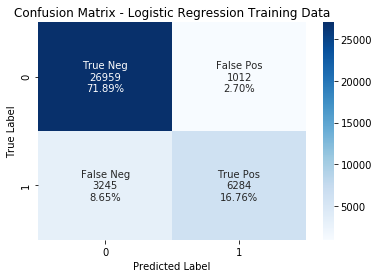

In [358]:
# visualize training confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                logreg_train_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     logreg_train_cf.flatten()/np.sum(logreg_train_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(logreg_train_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression Training Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

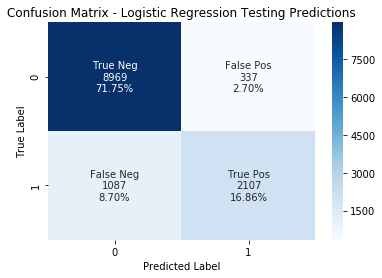

In [360]:
# visualize testing confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                logreg_test_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     logreg_test_cf.flatten()/np.sum(logreg_test_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(logreg_test_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression Testing Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Recall that the accuracy score for the Logistic Regression model is 88.61%. The confusion matrix shows that this breaks down to 71.75% True Negatives and 16.86% True Positives. Some imbalance between the positive class and the negative class likely has something to do with the higher rate of False Negatives over False Positives.

#### Receiver Operator Characteristic (ROC) Curve and AUC (Area Under the Curve)

The ROC curve illustrates the true positive rate against the false positive rate of my classification model. Put another way, gives shows the tradeoff between the false-positive and true-positive rate.

The AUC gives us a singular metric to compare these, where an AUC of 1 would mean the classifier is perfect.

In [390]:
# Calculate training ROC, AUC

fpr, tpr, thresholds = roc_curve(y_train, logreg_train_preds)
logreg_train_auc = round(auc(fpr, tpr),2)
logreg_train_auc

0.81

In [391]:
# Calculate testing ROC, AUC

fpr, tpr, thresholds = roc_curve(y_test, logreg_test_preds)
logreg_test_auc = round(auc(fpr, tpr),2)
logreg_test_auc

0.81

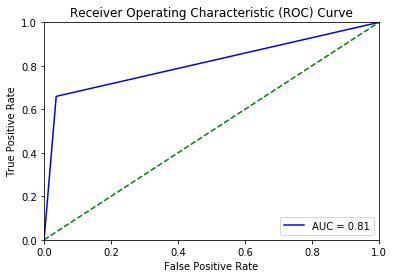

In [431]:
# Plot ROC and AUC on test predications

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % logreg_test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The best performing models will have an ROC curve that hugs the upper left corner of the graph.

Here, the false-positive rate accelerates as soon as the true-positive rate hits 0.65.

#### Metrics

In [374]:
print("Logistic Regression Model Performance Metrics - Training Predictions ")
print(classification_report(y_train, logreg_train_preds),'\n')
print("---------------------------------------------------------------\n")
print("Logistic Regression Model Performance Metrics - Testing Predictions ")
print(classification_report(y_test, logreg_test_preds))

Logistic Regression Model Performance Metrics - Training Predictions 
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     27971
           1       0.86      0.66      0.75      9529

    accuracy                           0.89     37500
   macro avg       0.88      0.81      0.84     37500
weighted avg       0.88      0.89      0.88     37500
 

---------------------------------------------------------------

Logistic Regression Model Performance Metrics - Testing Predictions 
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      9306
           1       0.86      0.66      0.75      3194

    accuracy                           0.89     12500
   macro avg       0.88      0.81      0.84     12500
weighted avg       0.88      0.89      0.88     12500



When interpreting the above evaluation metrics (accuracy, precision, recall, f1-score), it's necessary to take into account the use-case at hand.

- **Accuracy**: The rate of correct predictions, including both True Positives and True Negatives.

- **Precision**: The percentage of items that are correctly classified as relevant (How many of the selected items are relevant? Or, Number of True Positives / Number of Predicted Positives).

- **Recall**: The percentage of total relevant items correctly classified by model (How many of the relevant items are selected? Or, Number of True Positives / Number of Actual Total Positives.

- **F1 Score**: The harmonic mean of precision and recall (It weights both precision and recall equally, and penalizes when the model skews too hard toward one or the other.)

Given that the business case I've made up for this project involves the development of a mobile app that provides users with a prediction of whether a given flight will be delayed/canceled, **it seems that *precision* should be given priority over *recall***, since it would be better for a user to be told that his flight will depart on-time when it won't, than to be told that his flight would be delayed or canceled when it won't. Here, **the risk of missing a flight outweighs the potential reward of avoiding wait-times**. So, when the model predicts a positive (in this case, a delayed/canceled flight), then it better be a True Positive!

Of course, I also want the model to precisely catch *a high rate* of total canceled and delayed flights, meaning *recall* should have a place here as well. It'll be important to keep an eye on that F1 Score, in order to make sure that I'm not leaning too hard toward either precision or recall.

**Direct comparison of evaluation metrics for all models can be found near the bottom of this notebook.**

### Random Forest

#### Confusion Matrices

In [361]:
# create and print confusion matrices

rf_train_cf = confusion_matrix(y_train, rf_train_preds)
rf_test_cf = confusion_matrix(y_test, rf_test_preds)

print(f"Training data:\n {rf_train_cf}\n")
print(f"Testing data:\n {rf_test_cf}")

Training data:
 [[27395   576]
 [ 5100  4429]]

Testing data:
 [[9117  189]
 [1800 1394]]


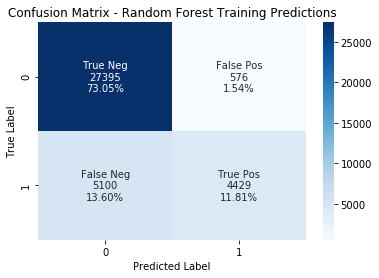

In [364]:
# visualize training confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                rf_train_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     rf_train_cf.flatten()/np.sum(rf_train_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(rf_train_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Training Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

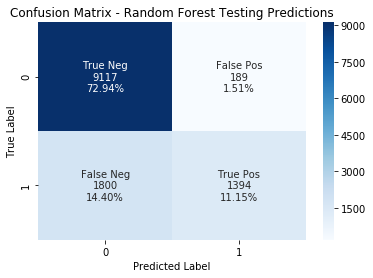

In [365]:
# visualize testing confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                rf_test_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     rf_test_cf.flatten()/np.sum(rf_test_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(rf_test_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Testing Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Recall that the accuracy score for the Random Forest model is 84.09%. The confusion matrix shows that this breaks down to 72.94% True Negatives and 11.15% True Positives. Some imbalance between the positive class and the negative class likely has something to do with the higher rate of False Negatives over False Positives.

While the accuracy was similar to that of the Logistic Regression model, the Random Forest model shows lower rates of True Positives and False Positives, and higher rates of True Negatives and False Negatives.

#### Receiver Operator Characteristic (ROC) Curve and AUC (Area Under the Curve)

In [379]:
# Calculate training ROC, AUC

fpr, tpr, thresholds = roc_curve(y_train, rf_train_preds)
rf_train_auc = round(auc(fpr, tpr),2)
rf_train_auc

0.72

In [381]:
# Calculate testing ROC, AUC

fpr, tpr, thresholds = roc_curve(y_test, rf_test_preds)
rf_test_auc = round(auc(fpr, tpr),2)
rf_test_auc

0.71

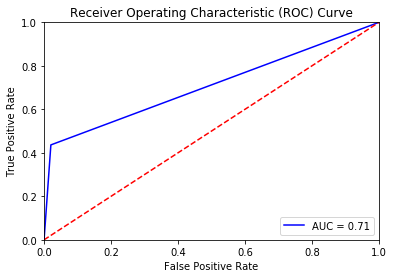

In [383]:
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % rf_test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Clearly, this is less encouraging that the ROC Curve of the Logistic Regression model. The false-positive rate accelerates as soon as the true-positive rate hits 0.45, and the AUC is much lower, at 0.71, which indicates that the model is still much better than random guessing, but is actually closer to random guessing than it is to perfection.

#### Metrics

In [377]:
print("Random Forest Model Performance Metrics - Training Predictions ")
print(classification_report(y_train, rf_train_preds),'\n')
print("---------------------------------------------------------------\n")
print("Random Forest Model Performance Metrics - Testing Predictions ")
print(classification_report(y_test, rf_test_preds))

Random Forest Model Performance Metrics - Training Predictions 
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     27971
           1       0.88      0.46      0.61      9529

    accuracy                           0.85     37500
   macro avg       0.86      0.72      0.76     37500
weighted avg       0.85      0.85      0.83     37500
 

---------------------------------------------------------------

Random Forest Model Performance Metrics - Testing Predictions 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      9306
           1       0.88      0.44      0.58      3194

    accuracy                           0.84     12500
   macro avg       0.86      0.71      0.74     12500
weighted avg       0.85      0.84      0.82     12500



### XGBoost

#### Confusion Matrices

In [363]:
# create and print confusion matrices

xgb_train_cf = confusion_matrix(y_train, xgb_train_preds)
xgb_test_cf = confusion_matrix(y_test, xgb_test_preds)

print(f"Training data:\n {xgb_train_cf}\n")
print(f"Testing data:\n {xgb_test_cf}")

Training data:
 [[27341   630]
 [ 1692  7837]]

Testing data:
 [[8977  329]
 [ 790 2404]]


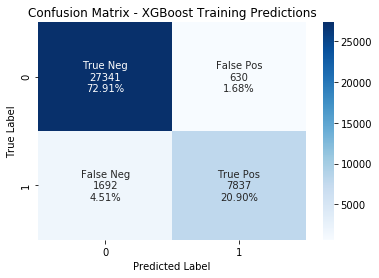

In [366]:
# visualize training confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                xgb_train_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     xgb_train_cf.flatten()/np.sum(xgb_train_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(xgb_train_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Training Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

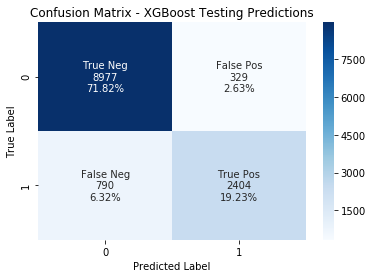

In [367]:
# visualize testing confusion matrix

# For sake of time, I'm making visualization manually
# In future, would be better to create function

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                xgb_test_cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     xgb_test_cf.flatten()/np.sum(xgb_test_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(xgb_test_cf, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Testing Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Of all three models, XGBoost shows the lowest rate of False Negatives and the highest rate of True Positives.

#### Receiver Operator Characteristic (ROC) Curve and AUC (Area Under the Curve)

In [387]:
# Calculate training ROC, AUC

fpr, tpr, thresholds = roc_curve(y_train, xgb_train_preds)
xgb_train_auc = round(auc(fpr, tpr),2)
xgb_train_auc

0.9

In [388]:
# Calculate testing ROC, AUC

fpr, tpr, thresholds = roc_curve(y_test, xgb_test_preds)
xgb_test_auc = round(auc(fpr, tpr),2)
xgb_test_auc

0.86

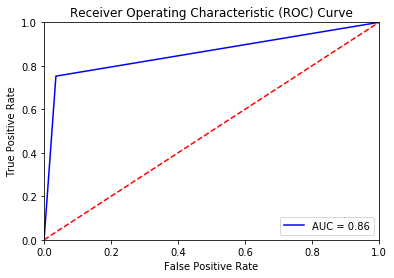

In [389]:
# Plot ROC and AUC on test predications

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % xgb_test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

XGBoost offers the strongest-looking ROC Curve of all, as the the False-Positive rate doesn't pivot to the right until the True-Positive rate gets to about 0.75. With this comes the highest AUC I've seen so far, at 0.86.

#### Metrics

In [378]:
print("XGBoost Model Performance Metrics - Training Predictions ")
print(classification_report(y_train, xgb_train_preds),'\n')
print("---------------------------------------------------------------\n")
print("XGBoost Model Performance Metrics - Testing Predictions ")
print(classification_report(y_test, xgb_test_preds))

XGBoost Model Performance Metrics - Training Predictions 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     27971
           1       0.93      0.82      0.87      9529

    accuracy                           0.94     37500
   macro avg       0.93      0.90      0.92     37500
weighted avg       0.94      0.94      0.94     37500
 

---------------------------------------------------------------

XGBoost Model Performance Metrics - Testing Predictions 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9306
           1       0.88      0.75      0.81      3194

    accuracy                           0.91     12500
   macro avg       0.90      0.86      0.88     12500
weighted avg       0.91      0.91      0.91     12500



### Comparing evaluation metrics of all three models:

In [412]:
print(f"Accuracy, Log Reg: {round(accuracy_score(y_test, logreg_test_preds),3)}")
print(f"Accuracy, Random Forest: {round(accuracy_score(y_test, rf_test_preds),3)}")
print(f"Accuracy, XGBoost: {round(accuracy_score(y_test, xgb_test_preds),3)}\n")

print(f"Precision, Log Reg: {round(precision_score(y_test, logreg_test_preds),3)}")
print(f"Precision, Random Forest: {round(precision_score(y_test, rf_test_preds),3)}")
print(f"Precision, XGBoost: {round(precision_score(y_test, xgb_test_preds),3)}\n")

print(f"Recall, Log Reg: {round(recall_score(y_test, logreg_test_preds),3)}")
print(f"Recall, Random Forest: {round(recall_score(y_test, rf_test_preds),3)}")
print(f"Recall, XGBoost: {round(recall_score(y_test, xgb_test_preds),3)}\n")

print(f"F1 Score, Log Reg: {round(f1_score(y_test, logreg_test_preds),3)}")
print(f"F1 Score, Random Forest: {round(f1_score(y_test, rf_test_preds),3)}")
print(f"F1 Score, XGBoost: {round(f1_score(y_test, xgb_test_preds),3)}")

Accuracy, Log Reg: 0.886
Accuracy, Random Forest: 0.841
Accuracy, XGBoost: 0.91

Precision, Log Reg: 0.862
Precision, Random Forest: 0.881
Precision, XGBoost: 0.88

Recall, Log Reg: 0.66
Recall, Random Forest: 0.436
Recall, XGBoost: 0.753

F1 Score, Log Reg: 0.747
F1 Score, Random Forest: 0.584
F1 Score, XGBoost: 0.811


Overall, **the highest-performing model was XGBoost**, as it outperformed the others in nearly every metric (with the exception of Precision, which narrowly went to Random Forest). Random Forest is the weakest of all three models, due mainly to its poor recall score; perhaps some parameter tweaking to do it some good. Let me see which features in the XGBoost model were the most influential:

In [38]:
def plot_feature_importances(model):
    '''Create visualization of feature importances from an ensemble model'''
    n_features = X_train.shape[1]
    plt.figure(figsize=(16,24))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.title('Feature Importance')
    plt.xlabel('Degree of Importance')
    plt.ylabel('Feature')

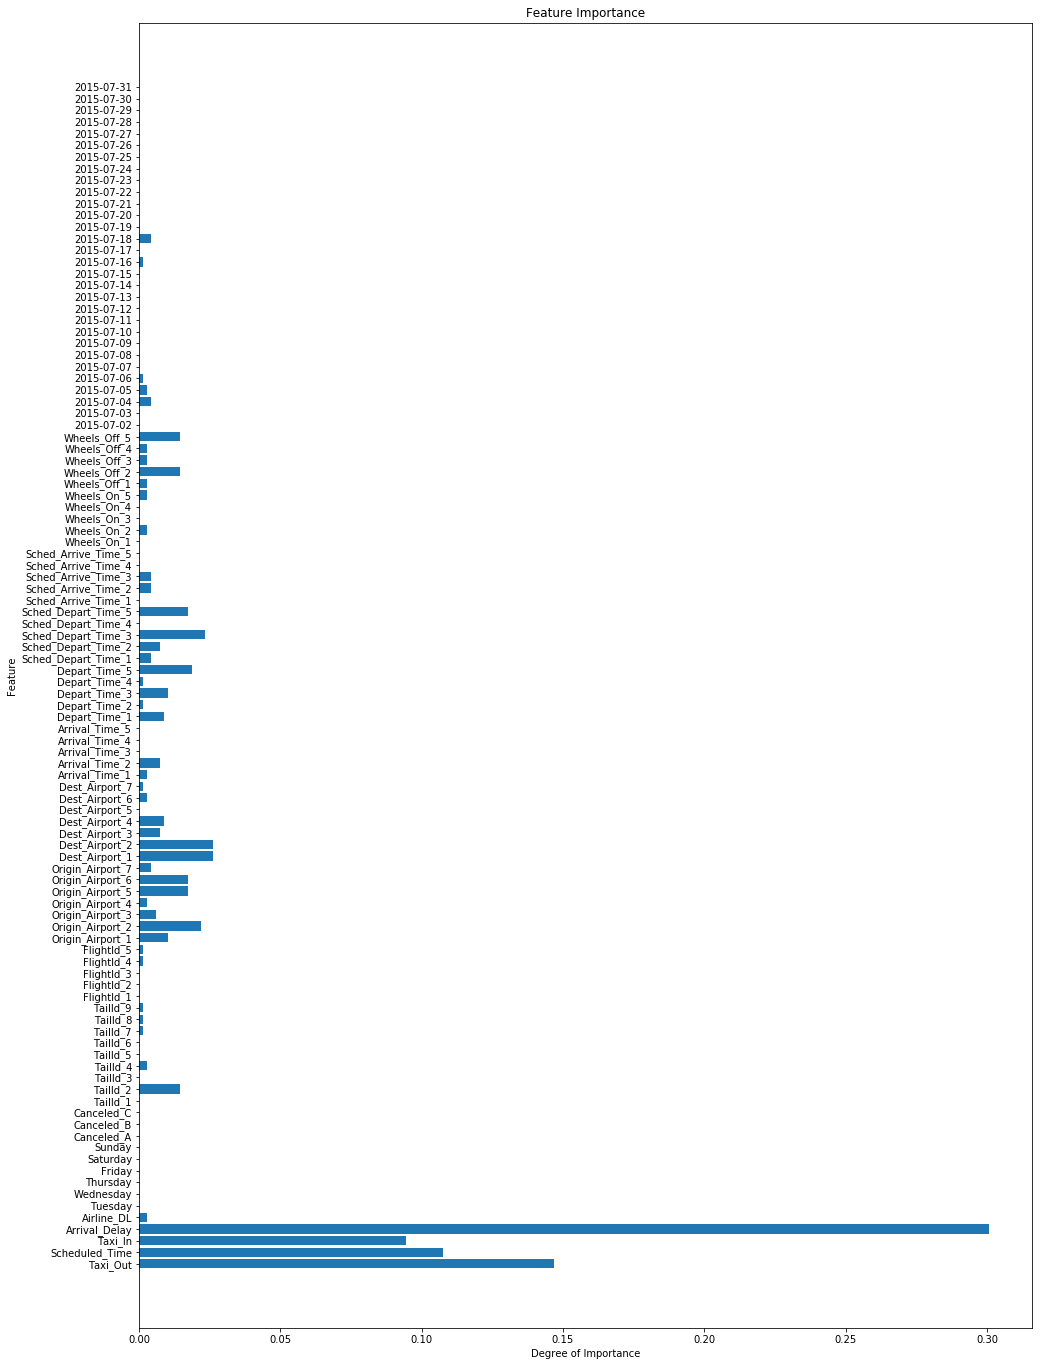

In [37]:
plot_feature_importances(model)

It looks like the most influential feature, by far, is `Arrival_Delay`, followed by `Taxi_Out` and `Scheduled_Time`. Most of the Date features appear to be of little or no influence. Day-of-week has no influence as well.

# Future work

- Look into possible class imbalance issue, which may be a culprit for poor Random Forest recall.
- Explore ways to reduce dimensionality of data, including ways to better integrate datetime data into models (e.g., [engineer more workable features](https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96) from the datetime data).
- When dimensionality is reduced and resources are freed up, explore how different parameters effect model performances.
- Since I'm trying to predict a delay or cancelation ahead of time, build model using only data that can be known pre-departure.